# Check issue with track cluster association


We (Michele and Dolores) think that the bad performance of the tagger comes from an issue in Pandora. The issue is that sometimes tracks get lost. I check this. 

In [1]:
save_status = False

In [2]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
def load_data(file_name):
    file = uproot.open(file_name)
    tree = file['tree;1']
    data = tree.arrays(library="np", entry_start=0, entry_stop=20000) #, entry_stop=1000000)
    return data

In [4]:
path= "/eos/experiment/fcc/ee/datasets/CLD_fullsim_tagging_trackPFOcheck/hadded_fakerate"
dic = {
    "bb": np.array([]),
    "gg": np.array([]),
    "tautau": np.array([])
}

for process in dic.keys():
    data = load_data(f"{path}/H{process}.root")
    dic[process] = data

In [5]:
dic["bb"].keys()

dict_keys(['recojet_isG', 'recojet_isU', 'recojet_isD', 'recojet_isS', 'recojet_isC', 'recojet_isB', 'recojet_isTAU', 'mcpid', 'mc_pfo_type', 'recopid', 'momentum', 'theta', 'energy', 'mc_track_found', 'pfo_recopid', 'pfo_momentum', 'pfo_theta', 'pfo_energy', 'pfo_MCpid', 'pfo_track'])

Ok, so **goal** for this notebook is to plot the fake rate for pfos. Next steps: 
- find index for e, mu, cha, nhad, photon in pfo `pfo_recopid`
- find good reco where `pfo_recopid` = `pfo_MCpid`
- plot 1 - fracation of good reco (fake rate) as a function of `pfo_theta` and `pfo_momentum` for different reco particle types: el, mu, chad, nhad, photons


In [6]:
np.unique(np.concatenate(dic["bb"]["pfo_recopid"])) 

array([-211,  -13,  -11,   11,   13,   22,  211, 2112], dtype=int32)

In [28]:
np.unique(abs(np.concatenate(dic["bb"]["pfo_MCpid"])), return_counts=True) 

(array([        11,         13,         22,        130,        211,
               310,        321,        411,        521,        999,
              2112,       2212,       3112,       3122,       3222,
              3312,       3322,       3334, 1000010020, 1000010030,
        1000020040], dtype=int32),
 array([ 66919,  17686, 427963,  20739, 454393,     39,  59640,      2,
             1,  32314,  15261,  27039,    444,     51,    407,    254,
             6,      4,     86,      3,      1]))

In [85]:
def to_had(pfo_MCpid):
    num_chad = [3334, 3312, 3222, 3112, 2212, 411, 321, 211, 521, 1000010020, 1000010030, 1000020040] # change to 211
    num_nhad = [3322, 2112, 3122, 130, 310] # change to 2112
    i_chad = np.where(np.isin(abs(pfo_MCpid), num_chad))
    pfo_MCpid[i_chad] = np.sign(pfo_MCpid[i_chad]) * 211
    i_nhad = np.where(np.isin(abs(pfo_MCpid), num_nhad))
    pfo_MCpid[i_nhad] = 2112
    return pfo_MCpid

In [100]:
def index_good_reco(Htype, ignore_sign=False):
    pfo_recopid = np.concatenate(dic[Htype]["pfo_recopid"])
    pfo_MCpid = np.concatenate(dic[Htype]["pfo_MCpid"])
    pfo_MCpid = to_had(pfo_MCpid)
    # unitl here seems correct
    # print(np.unique(pfo_MCpid, return_counts=True))
    if ignore_sign:
        i_good_reco = np.where(abs(pfo_recopid) == abs(pfo_MCpid))
        i_wrong_reco = np.where(abs(pfo_recopid) != abs(pfo_MCpid))
        wrong_types, counts = np.unique(pfo_MCpid[i_wrong_reco], return_counts=True)
    else: 
        i_good_reco = np.where(pfo_recopid == pfo_MCpid)
        i_wrong_reco = np.where(pfo_recopid != pfo_MCpid)
        wrong_types, counts = np.unique(pfo_MCpid[i_wrong_reco], return_counts=True)
    return i_good_reco, i_wrong_reco

In [22]:
index_good_reco("bb")

(array([-999, -211,  -13,  -11,   11,   13,   22,  211, 2112], dtype=int32), array([ 32314, 267632,   8882,  32923,  33996,   8804, 427963, 274642,
        36096]))


In [29]:
np.unique(np.concatenate(dic["bb"]["pfo_MCpid"]), return_counts=True) 

(array([     -3334,      -3322,      -3312,      -3222,      -3122,
             -3112,      -2212,      -2112,       -999,       -411,
              -321,       -211,        -13,        -11,         11,
                13,         22,        130,        211,        310,
               321,        411,        521,       2112,       2212,
              3112,       3122,       3222,       3312,       3322,
              3334, 1000010020, 1000010030, 1000020040], dtype=int32),
 array([     2,      2,    132,    193,     31,    242,  10507,   7934,
         32314,      1,  29833, 226722,   8882,  32923,  33996,   8804,
        427963,  20739, 227671,     39,  29807,      1,      1,   7327,
         16532,    202,     20,    214,    122,      4,      2,     86,
             3,      1]))

In [27]:
print("no MC info: ", np.round((32314/len(np.concatenate(dic["bb"]["pfo_MCpid"])))*100, 3), " %")

no MC info:  2.877  %


In [37]:
def ind_ptype(Htype):
    ind_e = np.where(abs(np.concatenate(dic[Htype]["pfo_recopid"])) == 11)
    ind_mu = np.where(abs(np.concatenate(dic[Htype]["pfo_recopid"])) == 13)
    ind_chad = np.where(abs(np.concatenate(dic[Htype]["pfo_recopid"])) == 211)
    ind_gamma = np.where(abs(np.concatenate(dic[Htype]["pfo_recopid"])) == 22)
    ind_nhad = np.where(abs(np.concatenate(dic[Htype]["pfo_recopid"])) == 2112)
    return ind_e, ind_mu, ind_chad, ind_gamma, ind_nhad

In [38]:
from functools import reduce

In [49]:
# Normalize function
def normalize_hist(data, ref_counts, bins, range):
    counts, _ = np.histogram(data, bins=bins, range=range, density=False)
    # Avoid division by zero by using np.where
    normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)
    return normalized_counts

In [104]:
def fake_rate(Htype):
    pfo_recopid = np.concatenate(dic[Htype]["pfo_recopid"])
    i_good_reco, i_wrong_reco = index_good_reco(Htype)
    if len(pfo_recopid) != (len(i_good_reco[0]) + len(i_wrong_reco[0])):
        raise ValueError("The number of good and wrong reco particles does not match the total number of particles")
    fakerate = len(i_wrong_reco[0]) / (len(i_good_reco[0]) + len(i_wrong_reco[0]))
    return fakerate
    

In [107]:
def fake_rate_x(Htype, ref_ind, ind_fake):
    """fake rate for e, mu, chad, gamma, nhad"""
    num_x = len(np.concatenate(dic[Htype]["pfo_recopid"])[ref_ind])
    num_fake_and_x = len(np.concatenate(dic[Htype]["pfo_recopid"])[ind_fake])
    return num_fake_and_x / num_x



In [132]:
def plot_fakerate(Htype, log_p = False):
    num_bins=50
    i_good_reco, i_wrong_reco = index_good_reco(Htype, ignore_sign=True)
    i_ptype = ind_ptype(Htype)
    labels = ["e", "muon", "chad", "photon", "nhad"]
    ranges = [[0, 60], [0, 3.14]]
    fig, ax = plt.subplots(2, 5, figsize=(23, 5))
    fig.suptitle(f"{Htype} fake rate ({np.round(fake_rate(Htype)*100, 1)} %)")
    for i in range(5):
        for j, obs in enumerate(["pfo_momentum", "pfo_theta"]):
            # Logarithmic binning for "momentum"
            if obs == "pfo_momentum" and log_p:
                bins = np.logspace(np.log10(ranges[j][0]+1e-1), np.log10(ranges[j][1]), num_bins)
                ax[j, i].set_xscale("log")
            else:
                bins = np.linspace(ranges[j][0], ranges[j][1], num_bins)



            ref_counts, bin_edges = np.histogram(np.concatenate(dic[Htype][obs])[i_ptype[i]], range=ranges[j], bins=bins, density=False)
            
            ind_interest = np.intersect1d(i_wrong_reco, i_ptype[i])
            # check which is the highest confusion
            pfo_MCpid = to_had(np.concatenate(dic[Htype]["pfo_MCpid"])[ind_interest])
            wrong_pid, counts = np.unique(abs(pfo_MCpid), return_counts=True)
            confusion = wrong_pid[np.argmax(counts)]
            obs_data = np.concatenate(dic[Htype][obs])[ind_interest]
            normalized_obs_data = normalize_hist(obs_data, ref_counts, bins, range=ranges[j])
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for plotting
            fakerate_ptype = fake_rate_x(Htype, i_ptype[i], ind_interest)
            ax[j, i].set_title(f"fake rate for {labels[i]}: {np.round(fakerate_ptype*100, 1)} %")
            ax[j, i].plot(bin_centers, normalized_obs_data, drawstyle='steps-mid', linewidth=2.0, label=f"{labels[i]} ({np.round(np.max(counts)*100/np.sum(counts), 1)} % confused with {confusion}" )#, label=f"MC {xtype}, track ({effi[2]} %)")
            ax[j, i].set_xlabel(f"{obs}")
            ax[j, i].set_ylabel("fake rate")

            #ax[j, i].hist(np.concatenate(dic[Htype]["pfo_momentum"])[i_ptype[i]], bins=100, histtype='step', label=labels[i])
            ax[j, i].grid()
            ax[j, i].legend()
            ax[j, i].set_ylim(0, 1.01)
            #ax[j, i].set_yscale('log')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2534442/1930759235.py:5: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


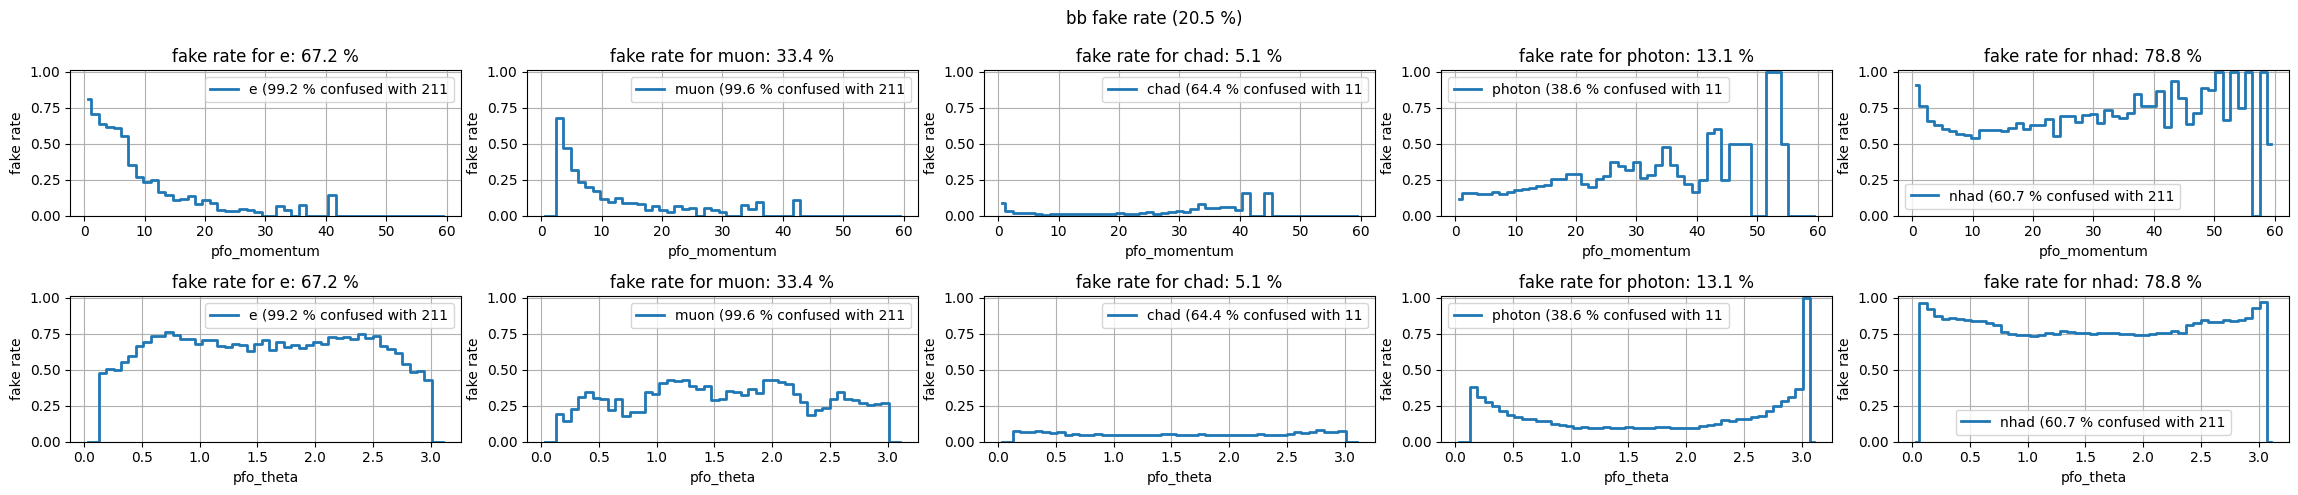

In [133]:
plot_fakerate("bb")

/tmp/ipykernel_2534442/1930759235.py:5: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


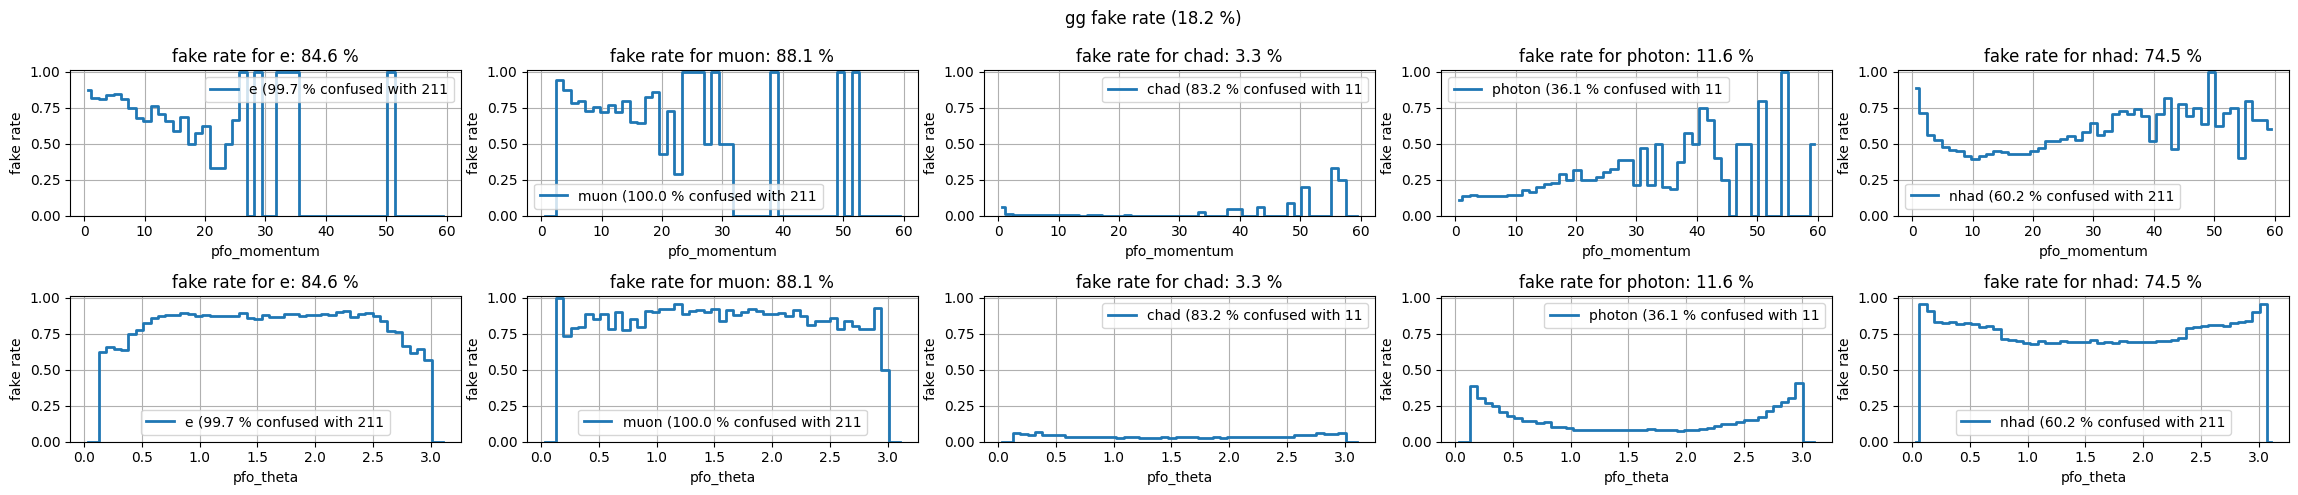

In [134]:
plot_fakerate("gg")

/tmp/ipykernel_2534442/1930759235.py:5: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


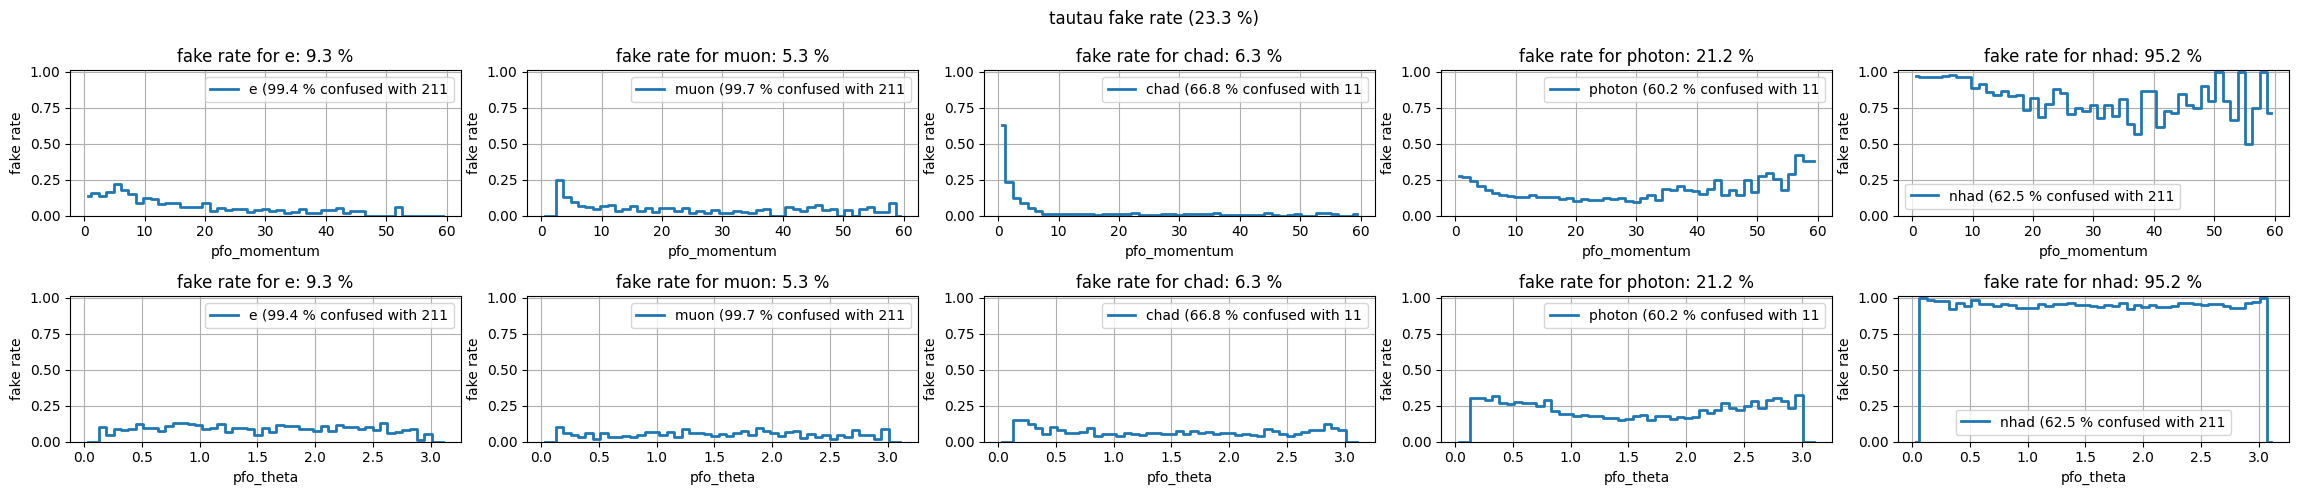

In [135]:
plot_fakerate("tautau")

Continue with: 
- what part of fake rate is not identified, what part is highest confusion?  Do that for neural hadrons!

In [7]:
ind_e = np.where(abs(np.concatenate(dic["bb"]["mcpid"])) == 11)
ind_mu = np.where(abs(np.concatenate(dic["bb"]["mcpid"])) == 13)
ind_chad = np.where(abs(np.concatenate(dic["bb"]["mcpid"])) == 211)

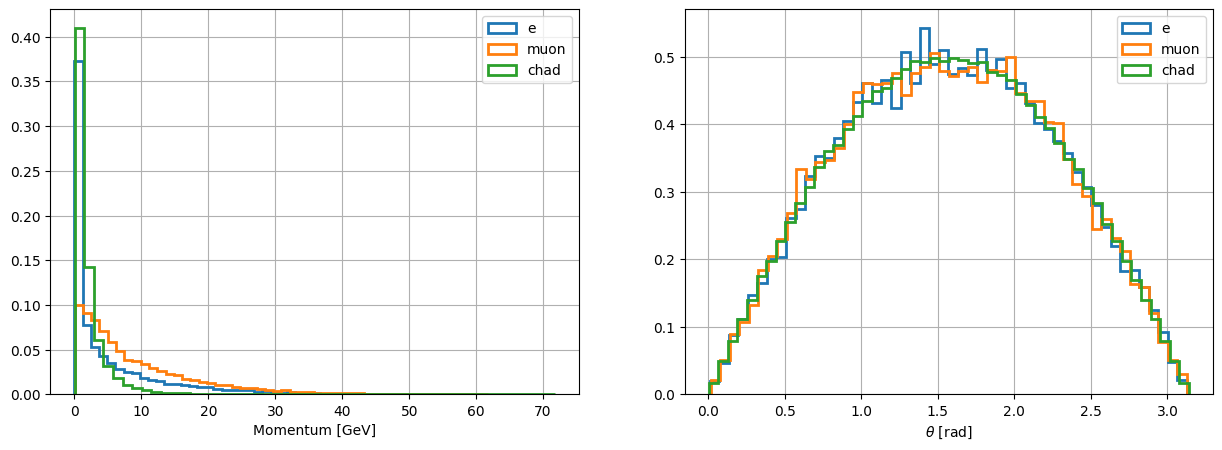

In [8]:
bins = 50
d = True
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist(np.concatenate(dic["bb"]["momentum"])[ind_e], bins=bins, histtype='step', linewidth=2.0, label="e", density=d)
ax[0].hist(np.concatenate(dic["bb"]["momentum"])[ind_mu], bins=bins, histtype='step', linewidth=2.0, label="muon", density=d)
ax[0].hist(np.concatenate(dic["bb"]["momentum"])[ind_chad], bins=bins, histtype='step', linewidth=2.0, label="chad", density=d)
ax[0].grid()
ax[0].legend()
ax[0].set_xlabel("Momentum [GeV]")

ax[1].hist(np.concatenate(dic["bb"]["theta"])[ind_e], bins=bins, histtype='step', linewidth=2.0, label="e", density=d)
ax[1].hist(np.concatenate(dic["bb"]["theta"])[ind_mu], bins=bins, histtype='step', linewidth=2.0, label="muon", density=d)
ax[1].hist(np.concatenate(dic["bb"]["theta"])[ind_chad], bins=bins, histtype='step', linewidth=2.0, label="chad", density=d)
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel(r"$\theta$ [rad]")

plt.show()

In [12]:
bins = 50

Now lets do these kind of plots but for each id (e, muon, chad) and in every histo, let's divide by the pfo track, pfo neutral of pfo loss.

In [5]:
def eff(Htype, ind):
    values, count = np.unique(np.concatenate(dic[Htype]["mc_pfo_type"])[ind], return_counts=True)
    #print("percentage of loss, neutral, track: ", np.round(count/np.sum(count)*100, 2), "%")
    if 0 not in values:
        count = np.insert(count, 0, 0)
    return np.round(count/np.sum(count)*100, 2)

# Normalize function
def normalize_hist(data, ref_counts, bins, range):
    counts, _ = np.histogram(data, bins=bins, range=range, density=False)
    # Avoid division by zero by using np.where
    normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)
    return normalized_counts


def subplot_pfo_div(j, ax, i_pfo_track, i_pfo_neutral, i_pfo_loss, l, Htype, ind_ptype):
    d=False
    ranges = [[0, 50], [0, 3.14]]
    xlabels = [r"$p$ [GeV]", r"$\theta$ [rad]"]
    num_bins = 60
    for i, obs in enumerate(["momentum", "theta"]):
        if Htype=="gg" and (l=="e" or l=="muon"):
            ranges[0] = [0, 15]
        # Logarithmic binning for "momentum"
        if obs == "momentum":
            bins = np.logspace(np.log10(ranges[i][0]+1e-1), np.log10(ranges[i][1]), num_bins)
            ax[i, j].set_xscale("log")
        else:
            bins = np.linspace(ranges[i][0], ranges[i][1], num_bins)
        # Calculate the reference histogram counts
        ref_counts, bin_edges = np.histogram(np.concatenate(dic[Htype][obs])[ind_ptype], bins=bins, range=ranges[i], density=d)

        # Normalize each histogram data
        track_data = np.concatenate(dic[Htype][obs])[i_pfo_track]
        neutral_data = np.concatenate(dic[Htype][obs])[i_pfo_neutral]
        loss_data = np.concatenate(dic[Htype][obs])[i_pfo_loss]
        
        normalized_track = normalize_hist(track_data, ref_counts, bins, range=ranges[i])
        normalized_neutral = normalize_hist(neutral_data, ref_counts, bins, range=ranges[i])
        normalized_loss = normalize_hist(loss_data, ref_counts, bins, range=ranges[i])

        # Plot normalized histograms
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for plotting
        effi = eff(Htype, ind_ptype)
        ax[i, j].plot(bin_centers, normalized_track, drawstyle='steps-mid', linewidth=2.0, label=f"MC {l}, track ({effi[2]}%)")
        ax[i, j].plot(bin_centers, normalized_neutral, drawstyle='steps-mid', linewidth=2.0, label=f"MC {l}, neutral ({effi[1]}%)")
        ax[i, j].plot(bin_centers, normalized_loss, drawstyle='steps-mid', linewidth=2.0, label=f"MC {l}, loss ({effi[0]}%)")
        ax[i, j].grid()
        ax[i, j].legend()
        ax[i, j].set_xlabel(xlabels[i])
        ax[i, j].set_ylabel("efficiency")

    
        


        """ax[0, j].hist(np.concatenate(dic[Htype][obs])[i_pfo_track], bins=bins, range=[0, 50], histtype='step', linewidth=2.0, label=f"MC {l}, track", density=d)
        ax[0, j].hist(np.concatenate(dic[Htype][obs])[i_pfo_neutral], bins=bins, range=[0, 50], histtype='step', linewidth=2.0, label=f"MC {l}, neutral", density=d)
        ax[0, j].hist(np.concatenate(dic[Htype][obs])[i_pfo_loss], bins=bins, range=[0, 50], histtype='step', linewidth=2.0, label=f"MC {l}, loss", density=d)
        ax[0, j].grid()
        ax[0, j].legend()
        ax[0, j].set_xlabel(f"MC {l}, Momentum [GeV]")
        ax[0, j].set_yscale("log")
        ax[1, j].hist(np.concatenate(dic[Htype]["theta"])[i_pfo_track], bins=bins, histtype='step', linewidth=2.0, label=f"MC {l}, track", density=d)
        ax[1, j].hist(np.concatenate(dic[Htype]["theta"])[i_pfo_neutral], bins=bins, histtype='step', linewidth=2.0, label=f"MC {l}, neutral", density=d)
        ax[1, j].hist(np.concatenate(dic[Htype]["theta"])[i_pfo_loss], bins=bins, histtype='step', linewidth=2.0, label=f"MC {l}, loss", density=d)
        ax[1, j].grid()
        ax[1, j].legend()
        ax[1, j].set_xlabel(r"$\theta$ [rad]")"""

**Task:** normalize over counts in each bin for distribution of all

In [6]:
def plot_pfo_alltype(Htype="bb", save=False):

    ind_e = np.where(abs(np.concatenate(dic[Htype]["mcpid"])) == 11)
    ind_mu = np.where(abs(np.concatenate(dic[Htype]["mcpid"])) == 13)
    ind_chad = np.where(abs(np.concatenate(dic[Htype]["mcpid"])) == 211)

    ind_pfo_track = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 2)
    ind_pfo_neutral = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 1)
    ind_pfo_loss = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 0)


    fig, ax = plt.subplots(2,3, figsize=(17,8))
    _, count = np.unique(np.concatenate(dic[Htype]["mc_pfo_type"]), return_counts=True)
    fig.suptitle(f"H{Htype} ({np.round(count/np.sum(count)*100, 2)[2]} % track eff.)")
    i_pfo_track = np.intersect1d(ind_pfo_track, ind_e)
    i_pfo_neutral = np.intersect1d(ind_pfo_neutral, ind_e)
    i_pfo_loss = np.intersect1d(ind_pfo_loss, ind_e)
    subplot_pfo_div(0,ax, i_pfo_track, i_pfo_neutral, i_pfo_loss, l="e", Htype=Htype, ind_ptype=ind_e)
    i_pfo_track = np.intersect1d(ind_pfo_track, ind_mu)
    i_pfo_neutral = np.intersect1d(ind_pfo_neutral, ind_mu)
    i_pfo_loss = np.intersect1d(ind_pfo_loss, ind_mu)
    subplot_pfo_div(1,ax, i_pfo_track, i_pfo_neutral, i_pfo_loss, l="muon", Htype=Htype, ind_ptype=ind_mu)
    i_pfo_track = np.intersect1d(ind_pfo_track, ind_chad)
    i_pfo_neutral = np.intersect1d(ind_pfo_neutral, ind_chad)
    i_pfo_loss = np.intersect1d(ind_pfo_loss, ind_chad)
    subplot_pfo_div(2,ax, i_pfo_track, i_pfo_neutral, i_pfo_loss, l="chad", Htype=Htype, ind_ptype=ind_chad)

    plt.tight_layout()
    if save:
        plt.savefig(f"./hist-trackPFOcheck/H{Htype}_trackeff.pdf")
    plt.show()

    

In [51]:
save_status = False

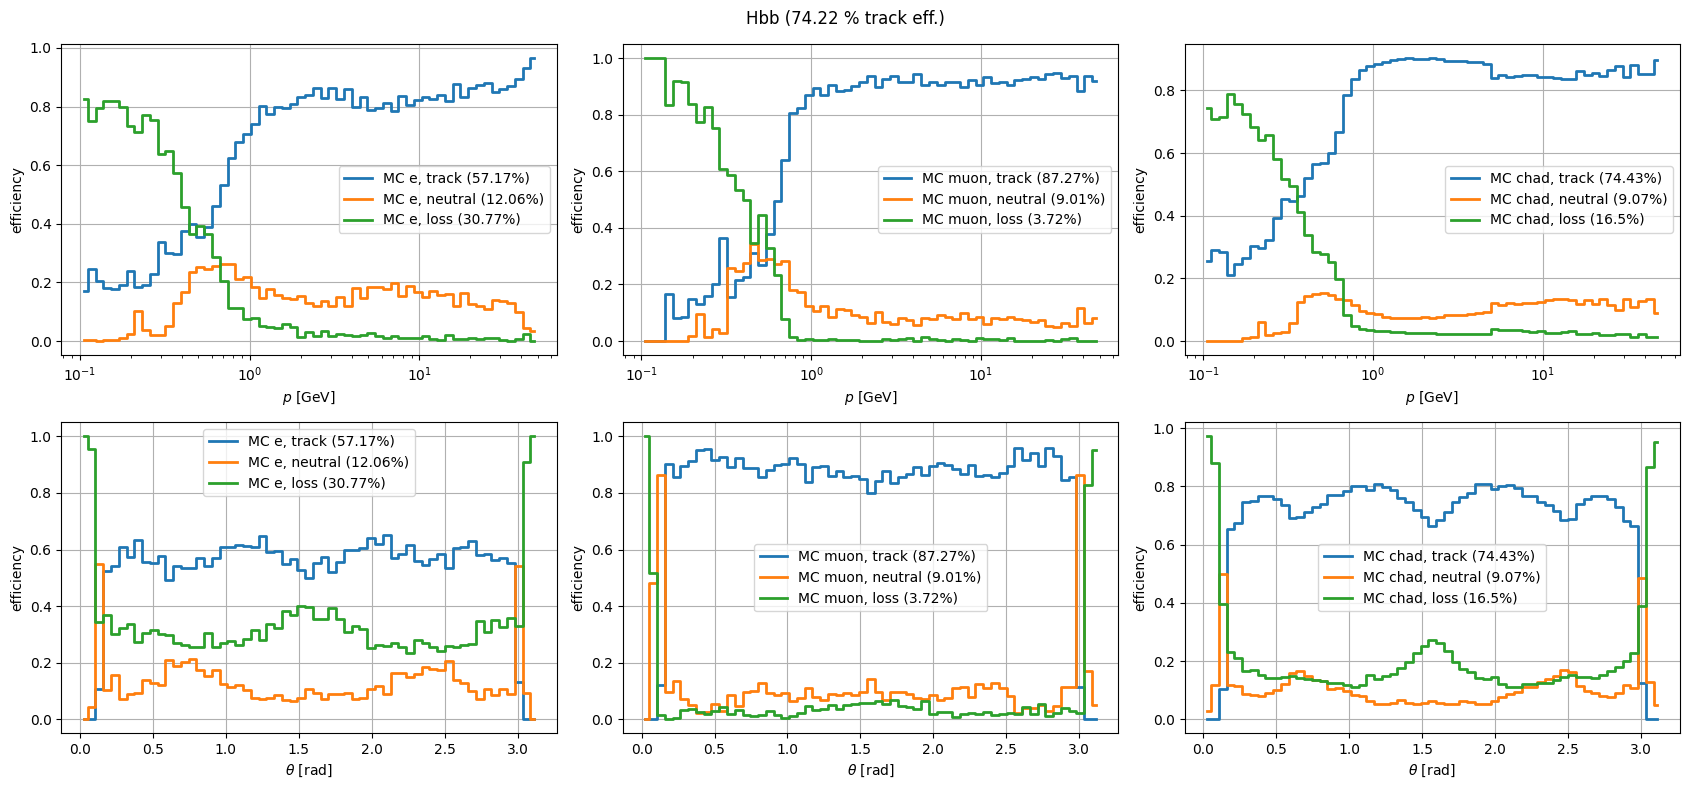

In [48]:
plot_pfo_alltype(Htype="bb", save=save_status)

Point out: 
- weird drop at 6 GeV for chad (not visible in muon -> pandora cut?)

/tmp/ipykernel_2462776/4179688729.py:12: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


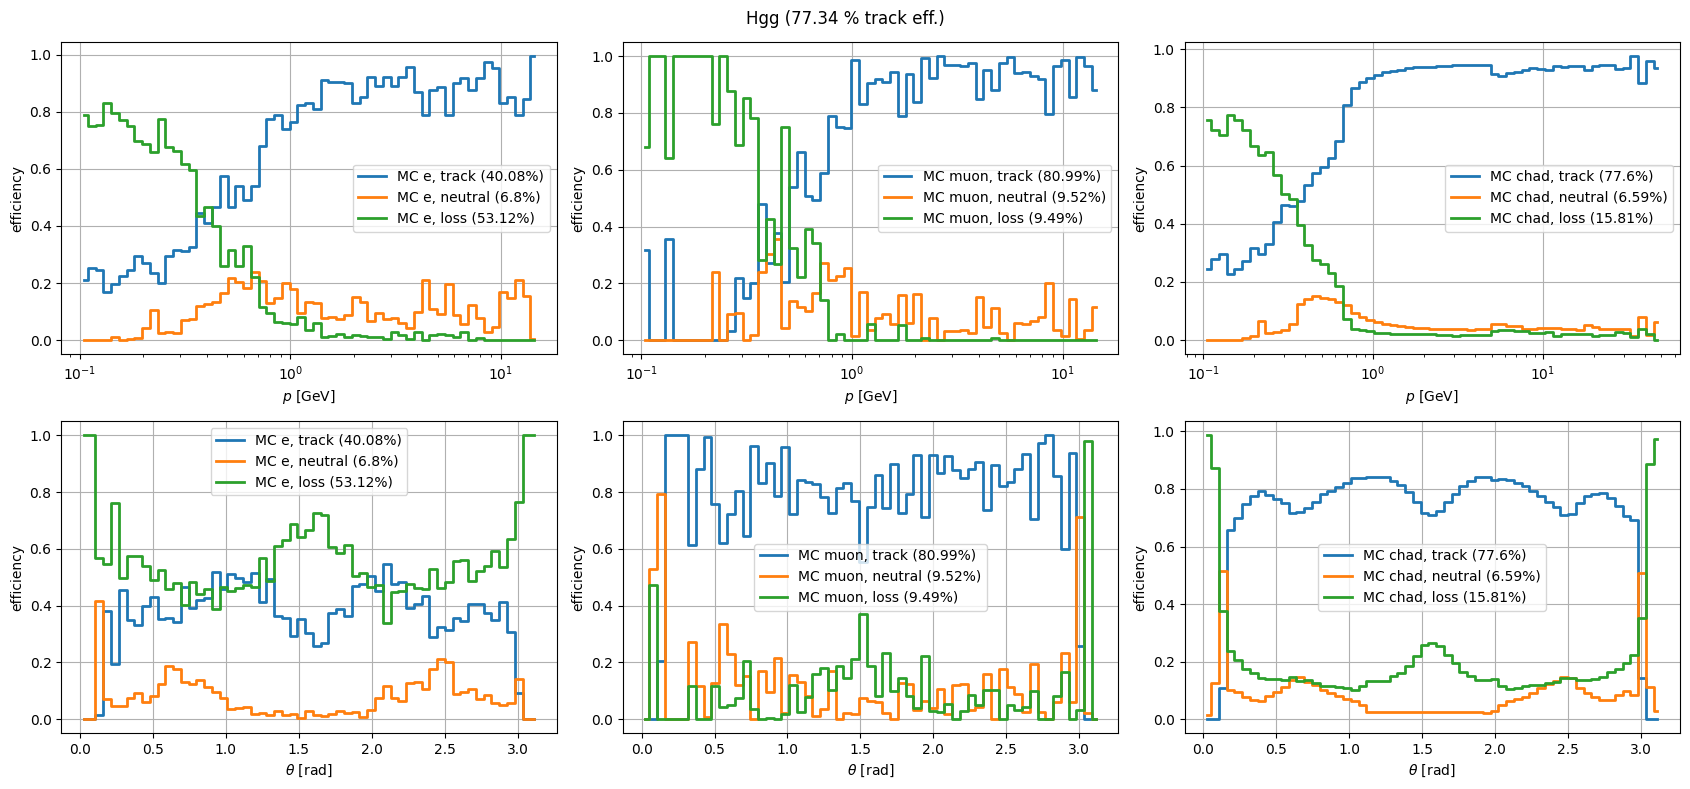

In [49]:
plot_pfo_alltype(Htype="gg", save=save_status)

Point out: 
- weird drop in chad at 6 GeV

/tmp/ipykernel_2462776/4179688729.py:12: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


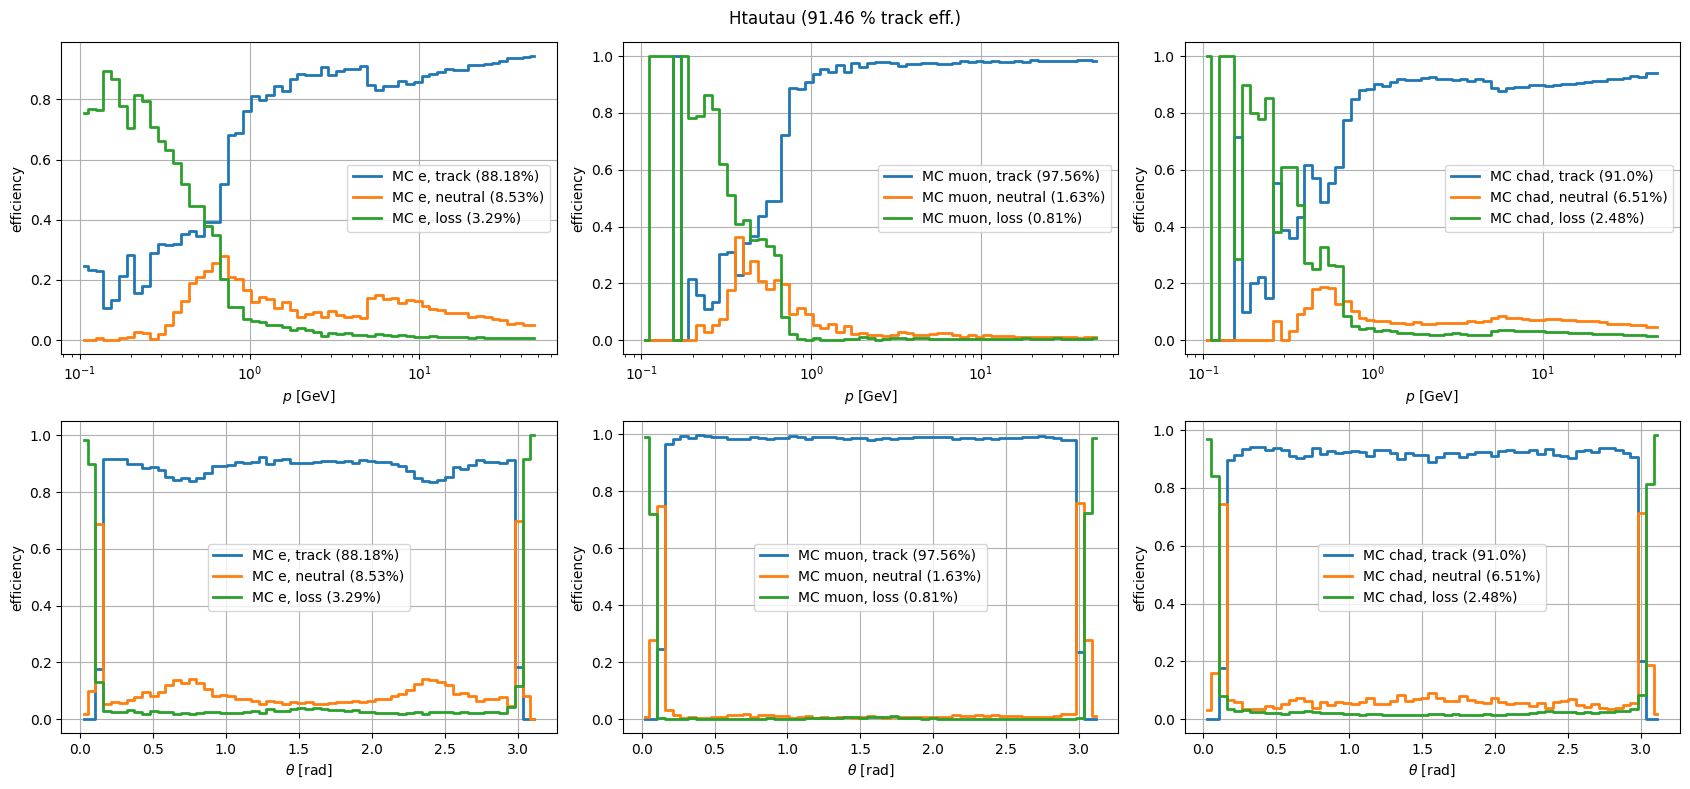

In [50]:
plot_pfo_alltype(Htype="tautau", save=save_status)

Point out: 
- weird drop at 6GeV in chad and electrons, not visible in muons -> pandora cut?

# Percentages

In [14]:
for key in ["gg", "tautau", "bb"]:
    print(key)
    _, count = np.unique(np.concatenate(dic[key]["mc_pfo_type"]), return_counts=True)
    print("percentage of loss, neutral, track: ", np.round(count/np.sum(count)*100, 2), "%")

gg
percentage of loss, neutral, track:  [16.06  6.6  77.34] %
tautau
percentage of loss, neutral, track:  [ 2.38  6.16 91.46] %
bb
percentage of loss, neutral, track:  [16.65  9.13 74.22] %


# 2D plots

plt.hist2d()

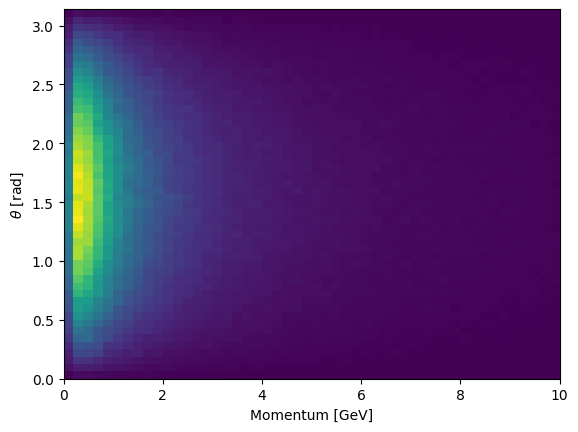

In [15]:
plt.hist2d(np.concatenate(dic["bb"]["momentum"]), np.concatenate(dic["bb"]["theta"]), bins=50, range=[[0, 10], [0, 3.14]])
plt.xlabel("Momentum [GeV]")
plt.ylabel(r"$\theta$ [rad]")
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_2d_hist(x_data, y_data, ref_counts, x_bins, y_bins):
    counts, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=[x_bins, y_bins], density=False)
    normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)
    return normalized_counts, x_edges, y_edges

def plot_2d_hist(ax, counts, x_edges, y_edges, xlabel, ylabel, label):
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    h = ax.pcolormesh(X, Y, counts.T, shading='auto', cmap='viridis')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(label)
    ax.set_xscale('log')
    plt.colorbar(h, ax=ax)

def subplot_pfo_2d(j, ax, i_pfo_track, i_pfo_neutral, i_pfo_loss, l, Htype, ind_ptype):
    if Htype=="gg" and (l=="e" or l=="muon"):
        ranges = [[0.1, 15], [0, 3.14]]  # Adjust the momentum range to avoid log(0)
    else:
        ranges = [[0.1, 50], [0, 3.14]]
    xlabels = [f"Momentum [GeV]", r"$\theta$ [rad]"]
    bins = 50

    # Extract data
    momentum_data = np.concatenate(dic[Htype]["momentum"])
    theta_data = np.concatenate(dic[Htype]["theta"])

    # Define selections
    track_data = (momentum_data[i_pfo_track], theta_data[i_pfo_track])
    neutral_data = (momentum_data[i_pfo_neutral], theta_data[i_pfo_neutral])
    loss_data = (momentum_data[i_pfo_loss], theta_data[i_pfo_loss])

    # Calculate log-spaced bins for momentum
    x_bins = np.logspace(np.log10(ranges[0][0]), np.log10(ranges[0][1]), bins)
    y_bins = np.linspace(ranges[1][0], ranges[1][1], bins)

    # Calculate the reference histogram counts
    ref_counts, x_edges, y_edges = np.histogram2d(momentum_data[ind_ptype], theta_data[ind_ptype], bins=[x_bins, y_bins], density=False)

    # Normalize histograms
    normalized_track, _, _ = normalize_2d_hist(*track_data, ref_counts, x_bins, y_bins)
    normalized_neutral, _, _ = normalize_2d_hist(*neutral_data, ref_counts, x_bins, y_bins)
    normalized_loss, _, _ = normalize_2d_hist(*loss_data, ref_counts, x_bins, y_bins)

    # Plot normalized 2D histograms
    plot_2d_hist(ax[0, j], normalized_track, x_bins, y_bins, xlabels[0], xlabels[1], f"MC {l}, track")
    plot_2d_hist(ax[1, j], normalized_neutral, x_bins, y_bins, xlabels[0], xlabels[1], f"MC {l}, neutral")
    plot_2d_hist(ax[2, j], normalized_loss, x_bins, y_bins, xlabels[0], xlabels[1], f"MC {l}, loss")

def plot_pfo_alltype_2d(Htype="bb", save=False):
    ind_e = np.where(abs(np.concatenate(dic[Htype]["mcpid"])) == 11)
    ind_mu = np.where(abs(np.concatenate(dic[Htype]["mcpid"])) == 13)
    ind_chad = np.where(abs(np.concatenate(dic[Htype]["mcpid"])) == 211)

    ind_pfo_track = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 2)
    ind_pfo_neutral = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 1)
    ind_pfo_loss = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 0)

    fig, ax = plt.subplots(3, 3, figsize=(17, 12))
    _, count = np.unique(np.concatenate(dic[Htype]["mc_pfo_type"]), return_counts=True)
    fig.suptitle(f"H{Htype} ({np.round(count / np.sum(count) * 100, 2)[2]} % track eff.)")

    i_pfo_track = np.intersect1d(ind_pfo_track, ind_e) # is electron and track
    i_pfo_neutral = np.intersect1d(ind_pfo_neutral, ind_e) # is electron but reco neutral
    i_pfo_loss = np.intersect1d(ind_pfo_loss, ind_e) # is electron but reco loss
    subplot_pfo_2d(0, ax, i_pfo_track, i_pfo_neutral, i_pfo_loss, l="e", Htype=Htype, ind_ptype=ind_e)
    
    i_pfo_track = np.intersect1d(ind_pfo_track, ind_mu)
    i_pfo_neutral = np.intersect1d(ind_pfo_neutral, ind_mu)
    i_pfo_loss = np.intersect1d(ind_pfo_loss, ind_mu)
    subplot_pfo_2d(1, ax, i_pfo_track, i_pfo_neutral, i_pfo_loss, l="muon", Htype=Htype, ind_ptype=ind_mu)
    
    i_pfo_track = np.intersect1d(ind_pfo_track, ind_chad)
    i_pfo_neutral = np.intersect1d(ind_pfo_neutral, ind_chad)
    i_pfo_loss = np.intersect1d(ind_pfo_loss, ind_chad)
    subplot_pfo_2d(2, ax, i_pfo_track, i_pfo_neutral, i_pfo_loss, l="chad", Htype=Htype, ind_ptype=ind_chad)

    plt.tight_layout()
    if save:
        plt.savefig(f"./hist-trackPFOcheck/H{Htype}_trackeff_2d.pdf")
    plt.show()

/tmp/ipykernel_2462776/2489225792.py:6: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


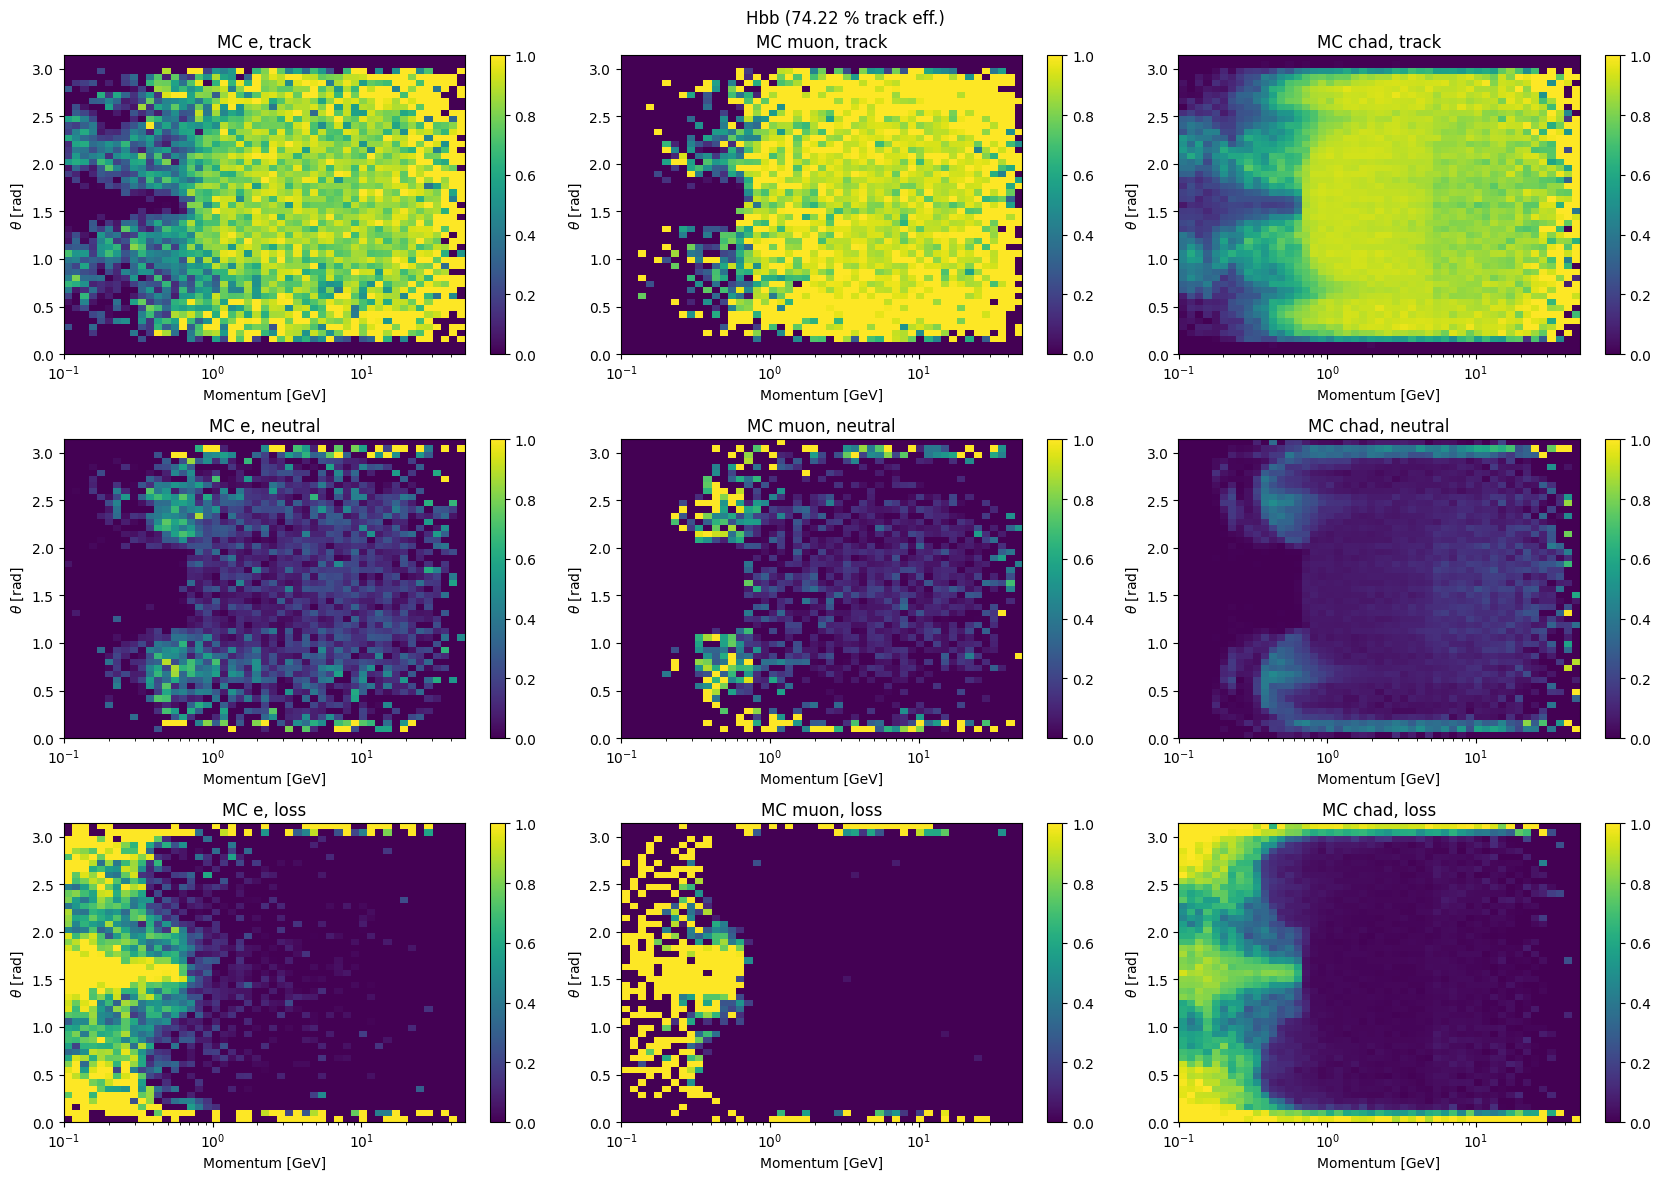

In [17]:
plot_pfo_alltype_2d(Htype="bb", save=save_status)


/tmp/ipykernel_2462776/2489225792.py:6: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


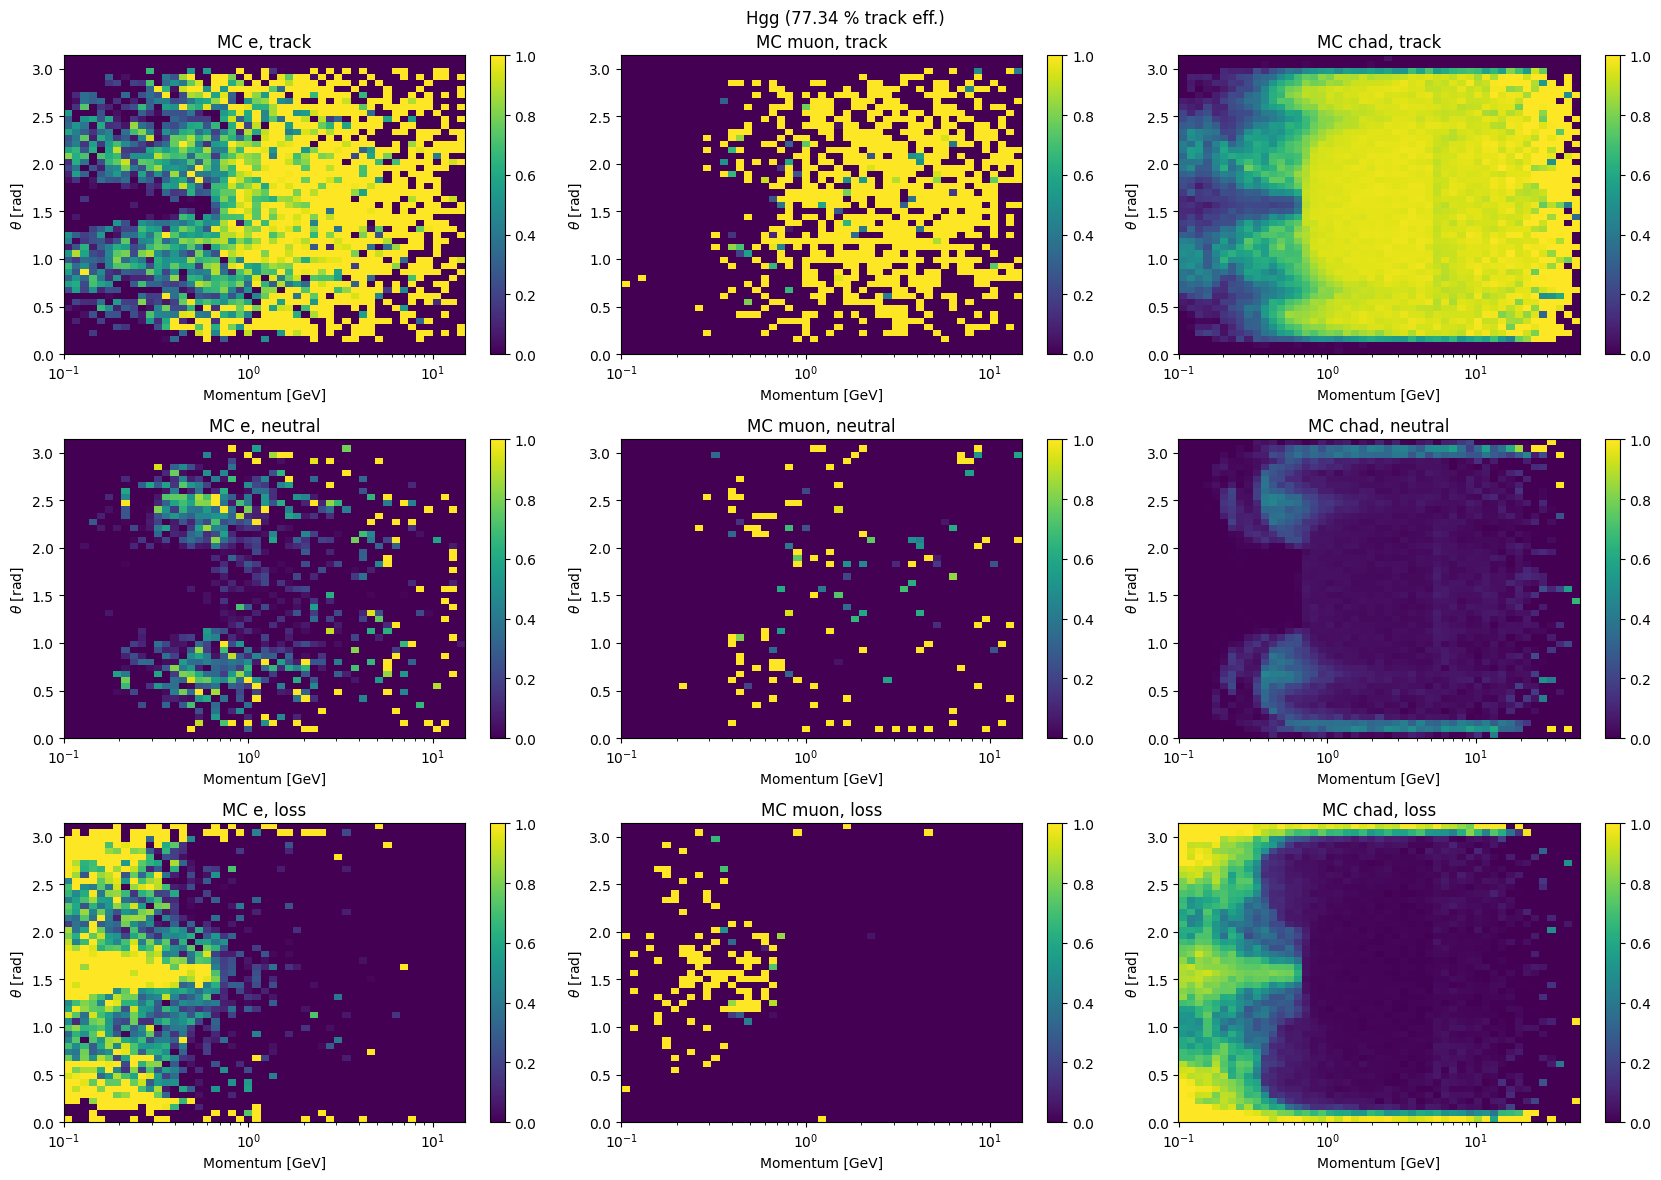

In [18]:
plot_pfo_alltype_2d(Htype="gg", save=save_status)

/tmp/ipykernel_2462776/2489225792.py:6: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


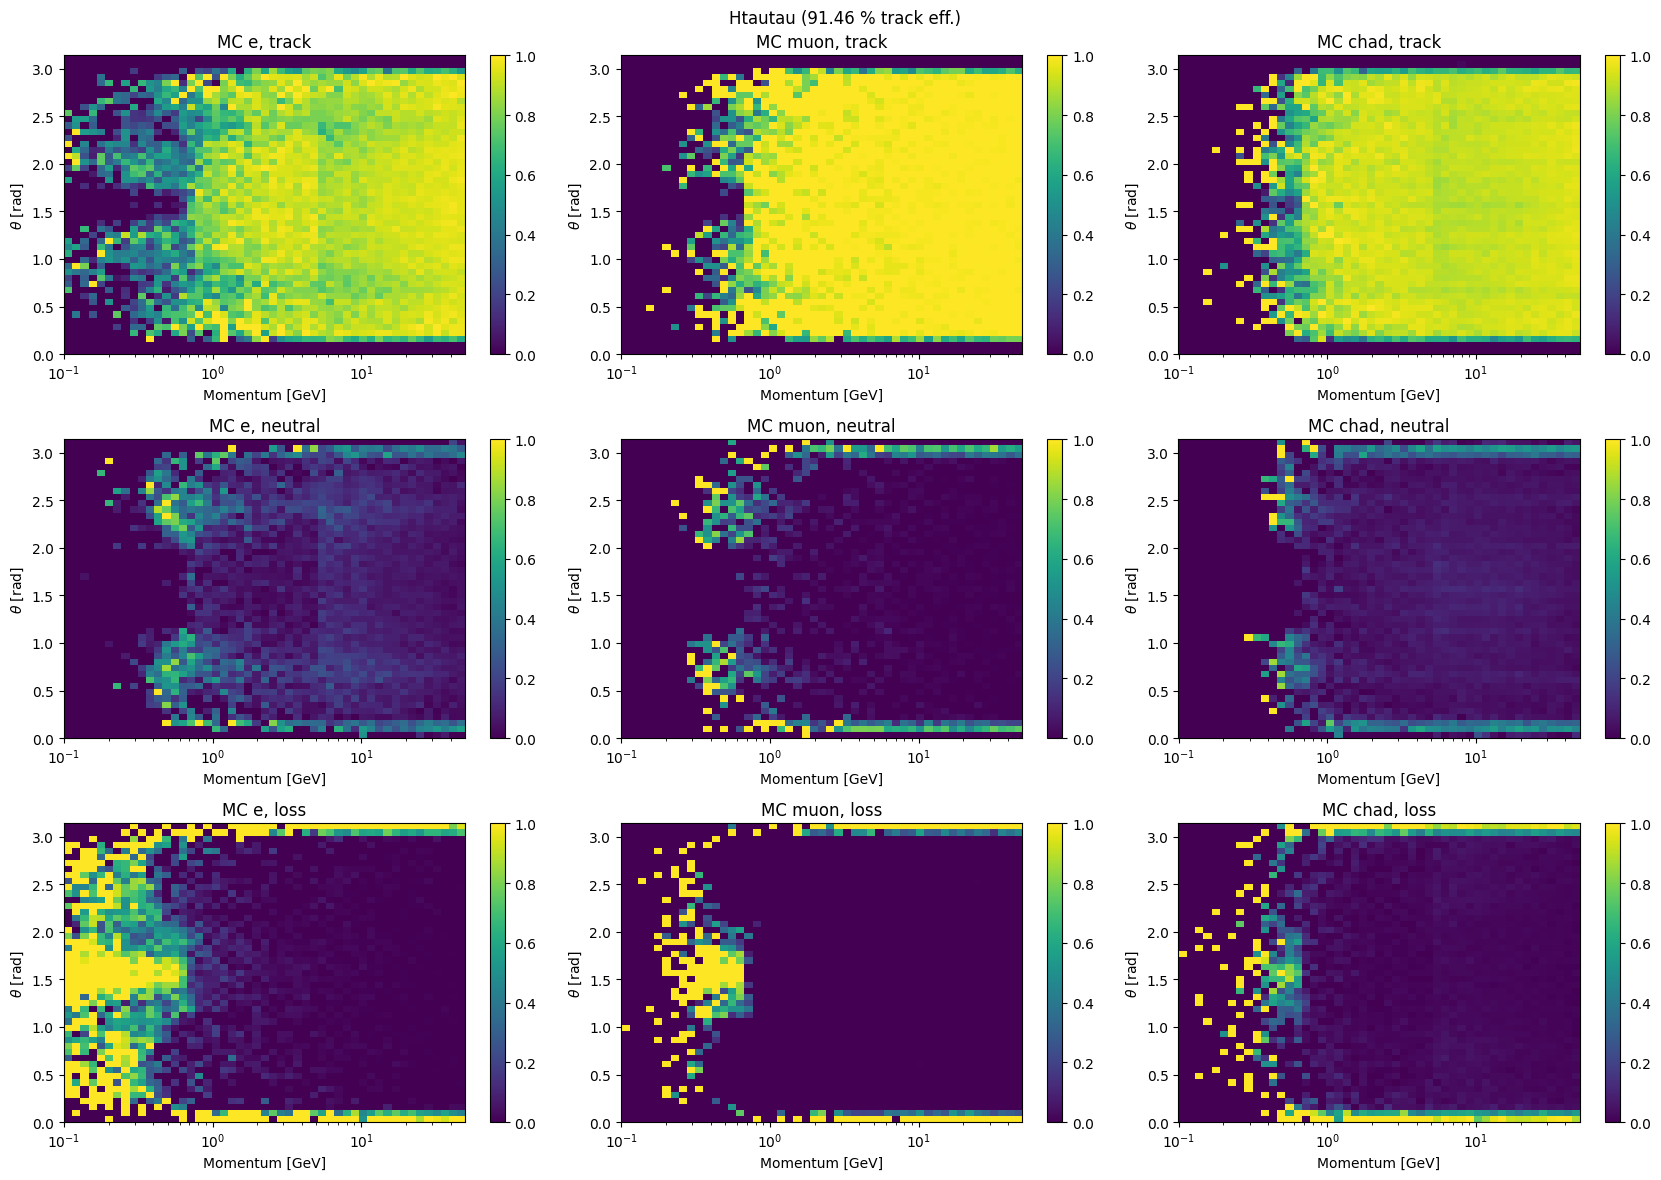

In [19]:
plot_pfo_alltype_2d(Htype="tautau", save=save_status)

# 1D plots but in slices

The idea is to do the plots again but in slices. 
- the $\theta$ plots in slices of p with $p<0.6$ GeV, $p \in [0.6, 5]$ GeV and $p>5$ GeV
- the $p$ plots in two slices to cover once the barral and once the endcap area. Chek out [this paper](https://arxiv.org/pdf/1911.12230) to get $\theta = \arctan \frac{r_{\mathrm{max}}}{z}$ considering the endcap geometries of the ECAL and HCAL. As $\theta$ goes from $[0, \pi]$, the barral region is $\theta \in [\frac{\pi}{4}, \frac{3\pi}{4}]$ and well the outer part for the barrel but I'll just use $|\cos\theta| < 0.7$ for the barrel and $|\cos\theta| >0.7$ for the endcaps.

In [20]:
print("ECAL ", np.arctan(2455/2300), " rad \t", np.round(np.arctan(2455/2300)*180/np.pi, 2), " deg")
print("HCAL ", np.arctan(3566/3705), " rad \t", np.round(np.arctan(3566/3705)*180/np.pi, 2), " deg")

ECAL  0.8179838910352395  rad 	 46.87  deg
HCAL  0.7662834514355346  rad 	 43.9  deg


In [21]:
np.cos(45*np.pi/180)

0.7071067811865476

In [9]:
from functools import reduce

In [10]:

def ind_x_type(Htype, x):
    if x=="e":
        ind_x = np.where(abs(np.concatenate(dic[Htype]["mcpid"])) == 11)
    elif x=="muon":
        ind_x = np.where(abs(np.concatenate(dic[Htype]["mcpid"])) == 13)
    elif x=="chad":
        ind_x = np.where(abs(np.concatenate(dic[Htype]["mcpid"])) == 211)
    return ind_x

def ind_p_cut(Htype, p_cut):
    data_p = np.concatenate(dic[Htype]["momentum"])
    if p_cut=="low":
        ind_p = np.where(data_p < 0.6)
    elif p_cut=="middle":
        ind_p = np.where((data_p >= 0.6) & (data_p <= 5))
    elif p_cut=="high":
        ind_p = np.where(data_p > 5)
    return ind_p

def ind_x_pfo_p(Htype, x, p_cut):
    ind_x = ind_x_type(Htype, x)
    ind_p = ind_p_cut(Htype, p_cut)

    ind_pfo_track = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 2)
    ind_pfo_neutral = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 1)
    ind_pfo_loss = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 0)

    ind_x_track_pcut = reduce(np.intersect1d, (ind_pfo_track, ind_x, ind_p))
    ind_x_neutral_pcut = reduce(np.intersect1d, (ind_pfo_neutral, ind_x, ind_p))
    ind_x_loss_pcut = reduce(np.intersect1d, (ind_pfo_loss, ind_x, ind_p))

    return ind_x_track_pcut, ind_x_neutral_pcut, ind_x_loss_pcut

def subplot_pfo_pcut(ax, Htype):
    ranges = [0, 3.14]
    p_cut_labels = [r"$p<0.6$ GeV", r"$0.6 < p < 5$ GeV", r"$p>5$ GeV"]
    for j, xtype in enumerate(["e", "muon", "chad"]):
        for i, p_cut in enumerate(["low", "middle", "high"]):
            ind_xtype = ind_x_type(Htype, xtype)
            ind_p = ind_p_cut(Htype, p_cut)
            ind_ref = reduce(np.intersect1d, (ind_xtype, ind_p))

            ref_counts, bin_edges = np.histogram(np.concatenate(dic[Htype]["theta"])[ind_ref], bins=bins, range=ranges, density=False)

            ind_x_track_pcut, ind_x_neutral_pcut, ind_x_loss_pcut = ind_x_pfo_p(Htype, xtype, p_cut)

            # Normalize each histogram data
            track_data = np.concatenate(dic[Htype]["theta"])[ind_x_track_pcut]
            neutral_data = np.concatenate(dic[Htype]["theta"])[ind_x_neutral_pcut]
            loss_data = np.concatenate(dic[Htype]["theta"])[ind_x_loss_pcut]

        
            normalized_track = normalize_hist(track_data, ref_counts, bins, range=ranges)
            normalized_neutral = normalize_hist(neutral_data, ref_counts, bins, range=ranges)
            normalized_loss = normalize_hist(loss_data, ref_counts, bins, range=ranges)

            # Plot normalized histograms
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for plotting
            ax[i, j].set_title(p_cut_labels[i])
            effi = eff(Htype, ind_ref)
            ax[i, j].plot(bin_centers, normalized_track, drawstyle='steps-mid', linewidth=2.0, label=f"MC {xtype}, track ({effi[2]} %)")
            ax[i, j].plot(bin_centers, normalized_neutral, drawstyle='steps-mid', linewidth=2.0, label=f"MC {xtype}, neutral ({effi[1]} %)")
            ax[i, j].plot(bin_centers, normalized_loss, drawstyle='steps-mid', linewidth=2.0, label=f"MC {xtype}, loss ({effi[0]} %)")
            ax[i, j].grid()
            ax[i, j].legend()
            ax[i, j].set_xlabel(r"$\theta$ [rad]")
            ax[i, j].set_ylabel("efficiency")

def plot_pfo_alltype_sliced_p(Htype="bb", save=False):
    """plot theta but for 3 different p cuts"""
    fig, ax = plt.subplots(3,3, figsize=(17,12))
    _, count = np.unique(np.concatenate(dic[Htype]["mc_pfo_type"]), return_counts=True)
    fig.suptitle(f"H{Htype} ({np.round(count/np.sum(count)*100, 2)[2]} % track eff.)")
    subplot_pfo_pcut(ax, Htype=Htype)

    plt.tight_layout()
    if save:
        plt.savefig(f"./hist-trackPFOcheck/H{Htype}_trackeff_sliced_p.pdf")
    plt.show()

/tmp/ipykernel_2489943/4179688729.py:12: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


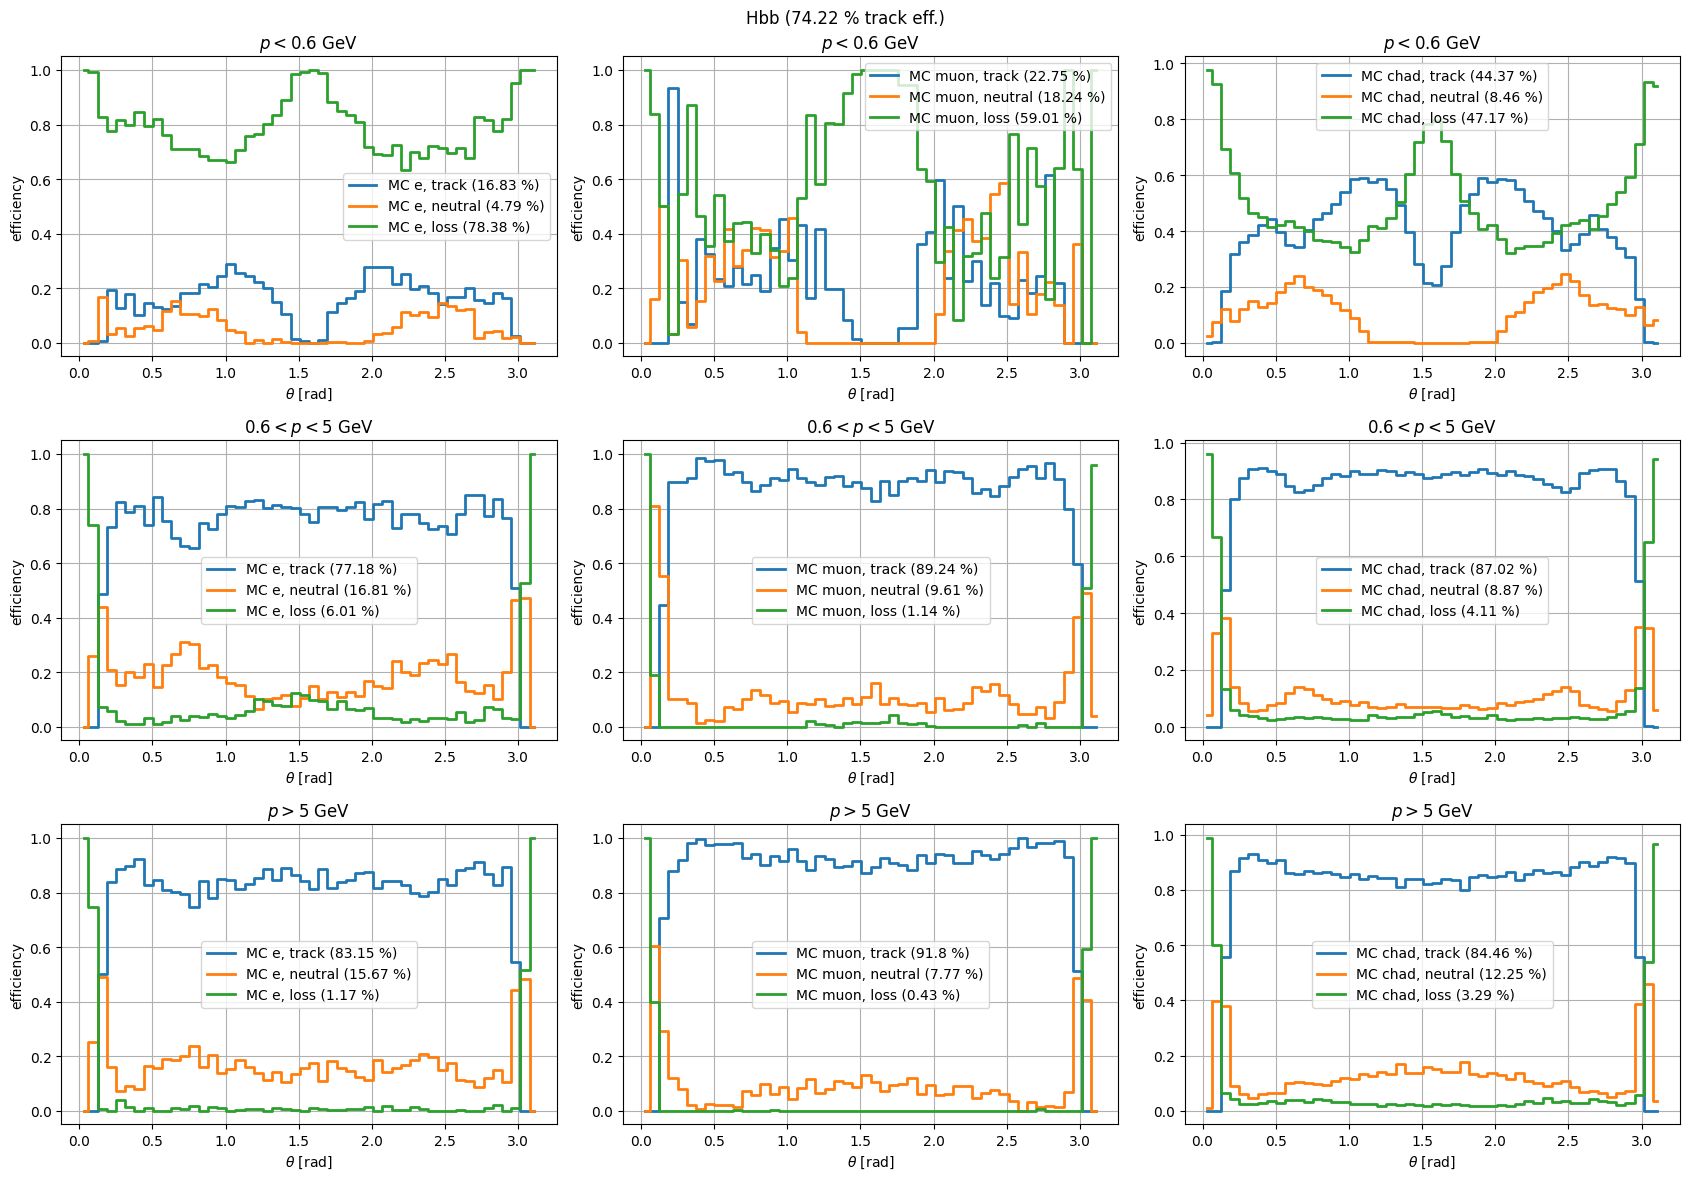

In [13]:
plot_pfo_alltype_sliced_p(Htype="bb", save=save_status)

/tmp/ipykernel_2489943/4179688729.py:12: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


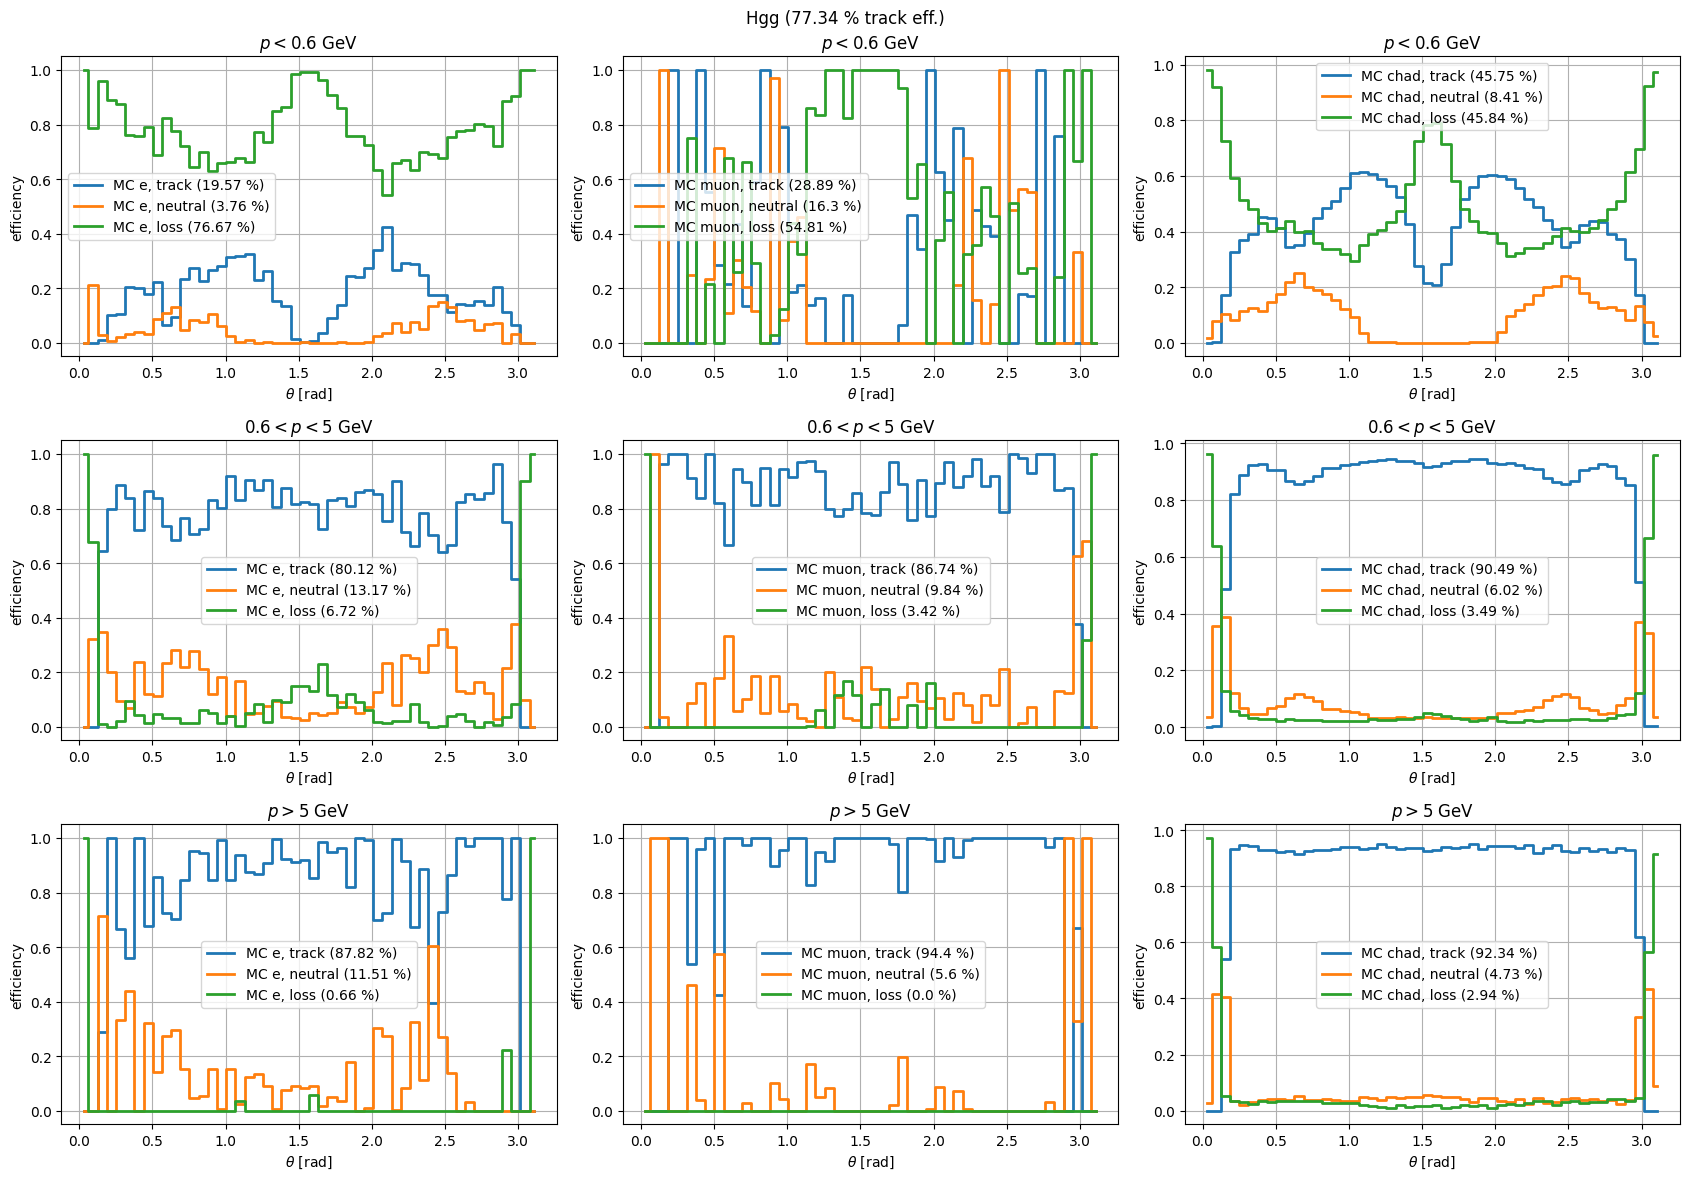

In [14]:
plot_pfo_alltype_sliced_p(Htype="gg", save=save_status)

/tmp/ipykernel_2489943/4179688729.py:12: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


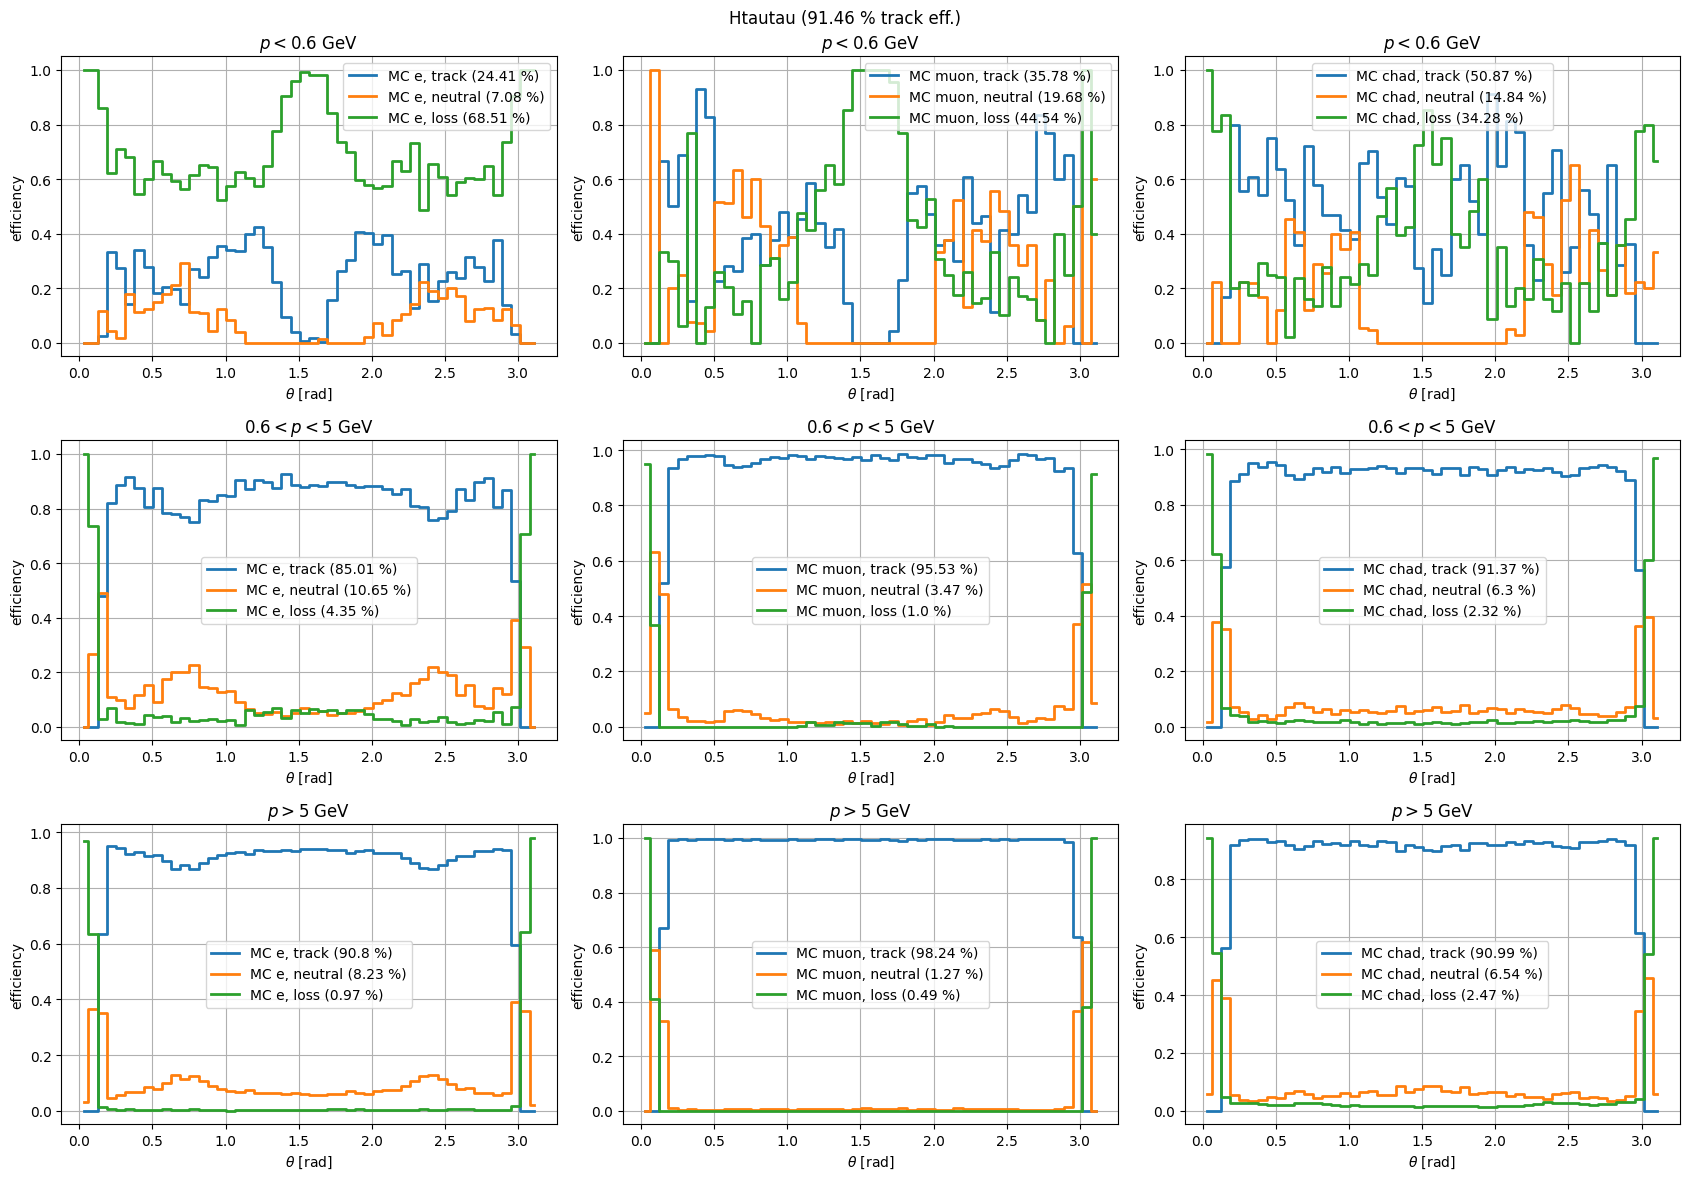

In [15]:
plot_pfo_alltype_sliced_p(Htype="tautau", save=save_status)

Now the theta cuts...

In [29]:
def ind_theta_cut(Htype, theta_cut):
    costheta_cut = 0.7
    if theta_cut=="barrel":
        ind_theta = np.where(np.abs(np.cos(np.concatenate(dic[Htype]["theta"]))) < costheta_cut)
    elif theta_cut=="endcap":
        ind_theta = np.where(np.abs(np.cos(np.concatenate(dic[Htype]["theta"]))) > costheta_cut)
    return ind_theta

def ind_x_pfo_theta(Htype, x, theta_cut):
    ind_x = ind_x_type(Htype, x)

    ind_pfo_track = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 2)
    ind_pfo_neutral = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 1)
    ind_pfo_loss = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 0)

    ind_theta = ind_theta_cut(Htype, theta_cut)

    ind_x_track_thetacut = reduce(np.intersect1d, (ind_pfo_track, ind_x, ind_theta))
    ind_x_neutral_thetacut = reduce(np.intersect1d, (ind_pfo_neutral, ind_x, ind_theta))
    ind_x_loss_thetacut = reduce(np.intersect1d, (ind_pfo_loss, ind_x, ind_theta))

    return ind_x_track_thetacut, ind_x_neutral_thetacut, ind_x_loss_thetacut

def subplot_pfo_thetacut(ax, Htype):
    num_bins = 60
    # Logarithmic binning for "momentum"
    ranges = [0, 50]
    bins = np.logspace(np.log10(ranges[0]+1e-1), np.log10(ranges[1]), num_bins)
    theta_cut_labels = [r"$|\cos\theta|<0.7$ (barrel)", r"$|\cos\theta|>0.7$ (endcap)"]
    for j, xtype in enumerate(["e", "muon", "chad"]):
        if Htype=="gg" and (xtype=="e" or xtype=="muon"):
            ranges = [0, 15]
        for i, theta_cut in enumerate(["barrel", "endcap"]):
            ind_xtype = ind_x_type(Htype, xtype)
            ind_theta = ind_theta_cut(Htype, theta_cut)
            ind_ref = reduce(np.intersect1d, (ind_xtype, ind_theta))

            ref_counts, bin_edges = np.histogram(np.concatenate(dic[Htype]["momentum"])[ind_ref], bins=bins, range=ranges, density=False)

            ind_x_track_thetacut, ind_x_neutral_thetacut, ind_x_loss_thetacut = ind_x_pfo_theta(Htype, xtype, theta_cut)

            # Normalize each histogram data
            track_data = np.concatenate(dic[Htype]["momentum"])[ind_x_track_thetacut]
            neutral_data = np.concatenate(dic[Htype]["momentum"])[ind_x_neutral_thetacut]
            loss_data = np.concatenate(dic[Htype]["momentum"])[ind_x_loss_thetacut]

        
            normalized_track = normalize_hist(track_data, ref_counts, bins, range=ranges)
            normalized_neutral = normalize_hist(neutral_data, ref_counts, bins, range=ranges)
            normalized_loss = normalize_hist(loss_data, ref_counts, bins, range=ranges)

            # Plot normalized histograms
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for plotting
            ax[i, j].set_title(theta_cut_labels[i])
            effi = eff(Htype, ind_ref)
            ax[i, j].plot(bin_centers, normalized_track, drawstyle='steps-mid', linewidth=2.0, label=f"MC {xtype}, track ({effi[2]} %)")
            ax[i, j].plot(bin_centers, normalized_neutral, drawstyle='steps-mid', linewidth=2.0, label=f"MC {xtype}, neutral ({effi[1]} %)")
            ax[i, j].plot(bin_centers, normalized_loss, drawstyle='steps-mid', linewidth=2.0, label=f"MC {xtype}, loss ({effi[0]} %)")
            ax[i, j].grid()
            ax[i, j].legend()
            ax[i, j].set_xscale("log")
            ax[i, j].set_xlabel(r"$p$ [GeV]")
            ax[i, j].set_ylabel("efficiency")

def plot_pfo_alltype_sliced_theta(Htype="bb", save=False):
    """plot theta but for 3 different p cuts"""
    fig, ax = plt.subplots(2,3, figsize=(17,8))
    _, count = np.unique(np.concatenate(dic[Htype]["mc_pfo_type"]), return_counts=True)
    fig.suptitle(f"H{Htype} ({np.round(count/np.sum(count)*100, 2)[2]} % track eff.)")
    subplot_pfo_thetacut(ax, Htype=Htype)

    plt.tight_layout()
    if save:
        plt.savefig(f"./hist-trackPFOcheck/H{Htype}_trackeff_sliced_theta.pdf")
    plt.show()

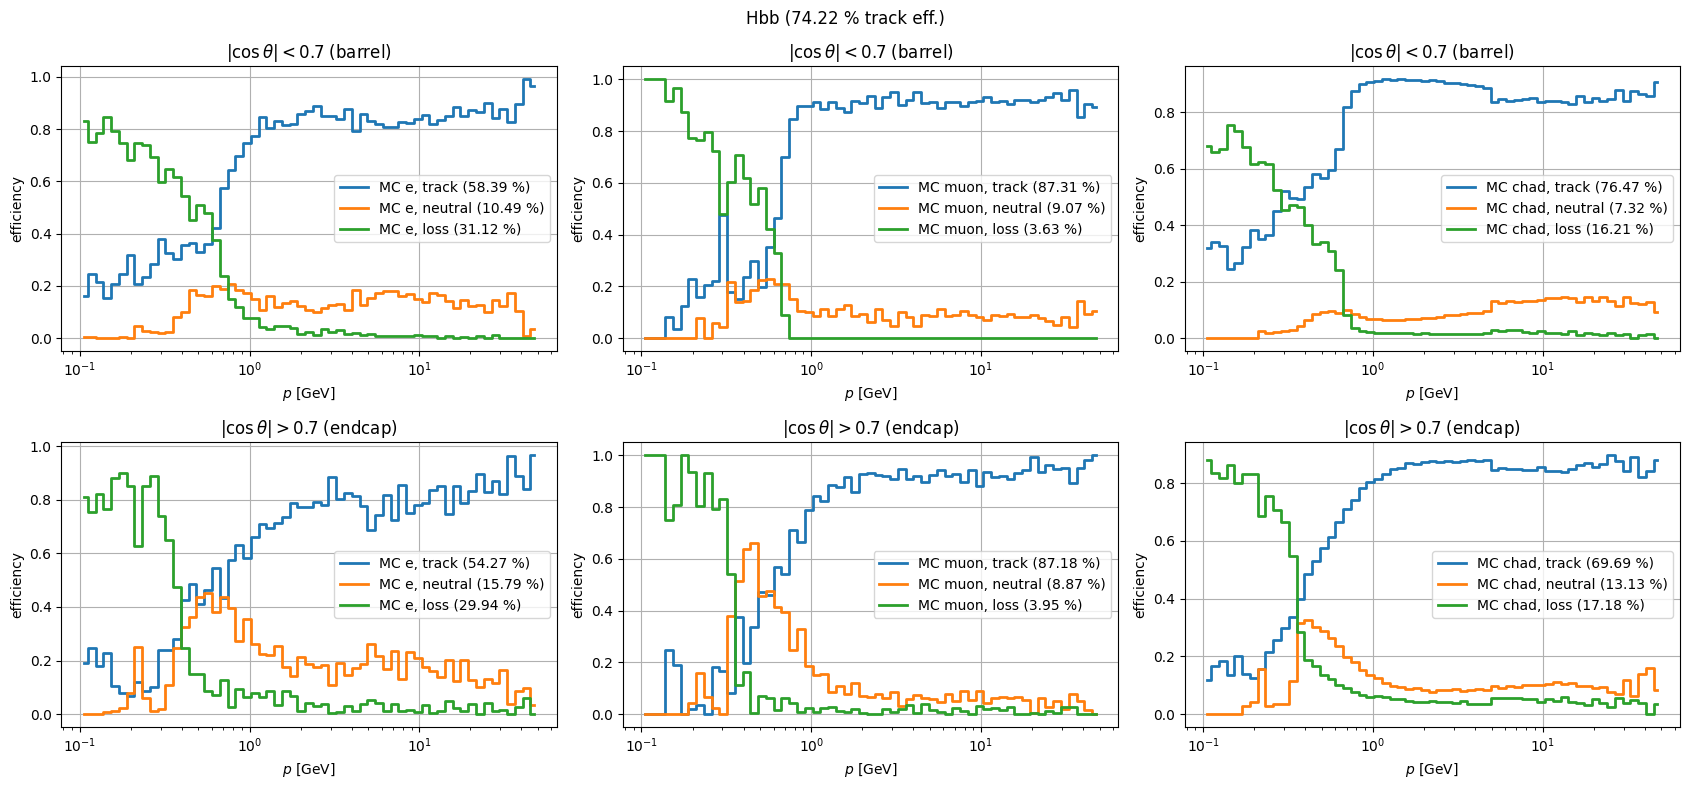

In [30]:
plot_pfo_alltype_sliced_theta(Htype="bb", save=save_status)

/tmp/ipykernel_2462776/4175067641.py:10: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


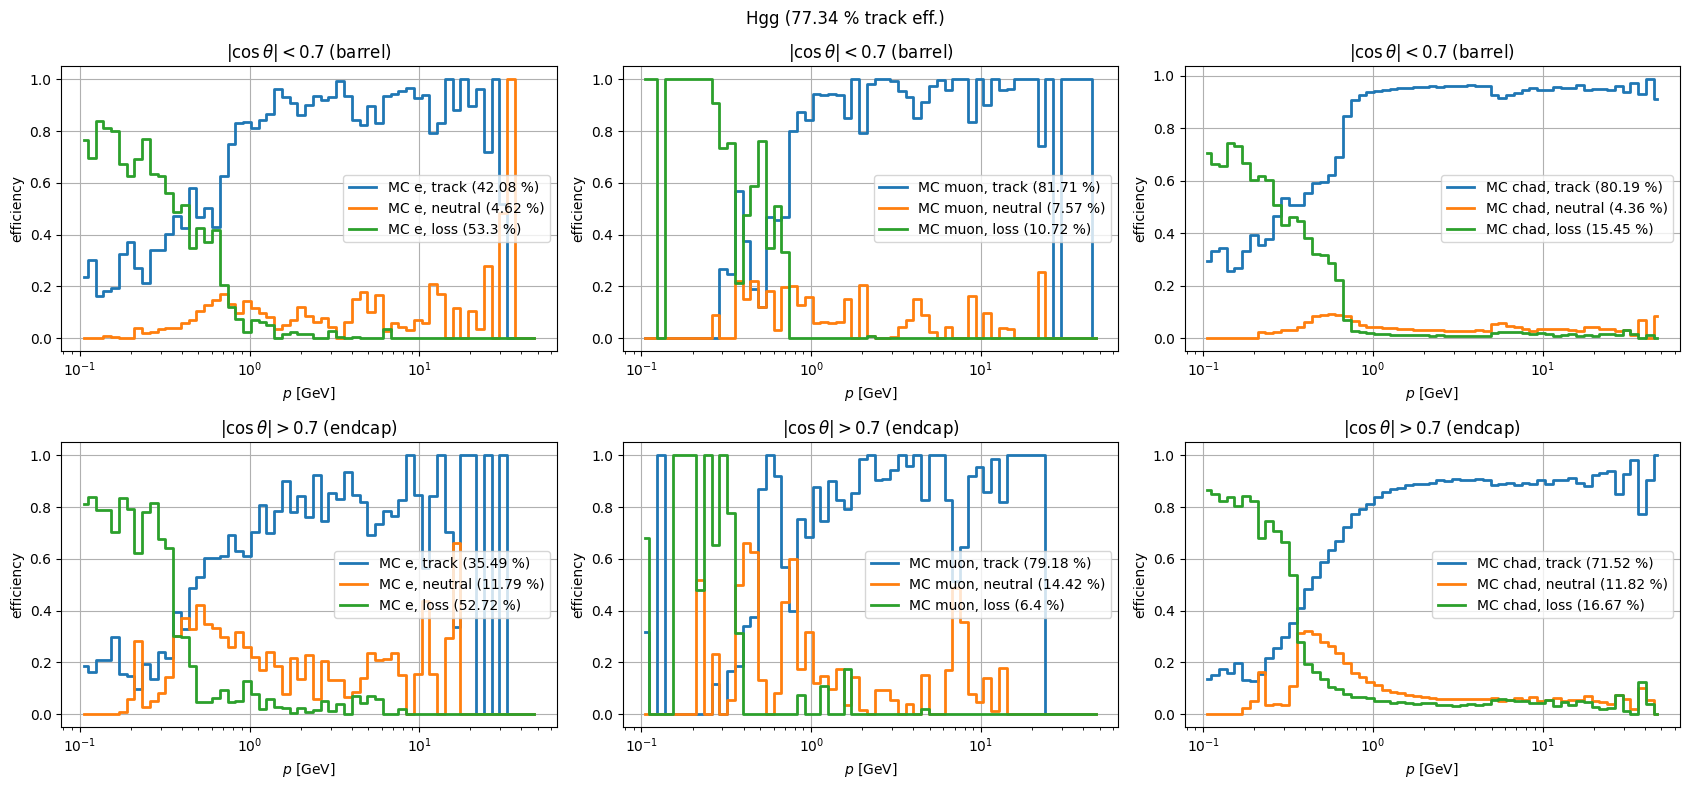

In [31]:
plot_pfo_alltype_sliced_theta(Htype="gg", save=save_status)

/tmp/ipykernel_2462776/4175067641.py:10: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


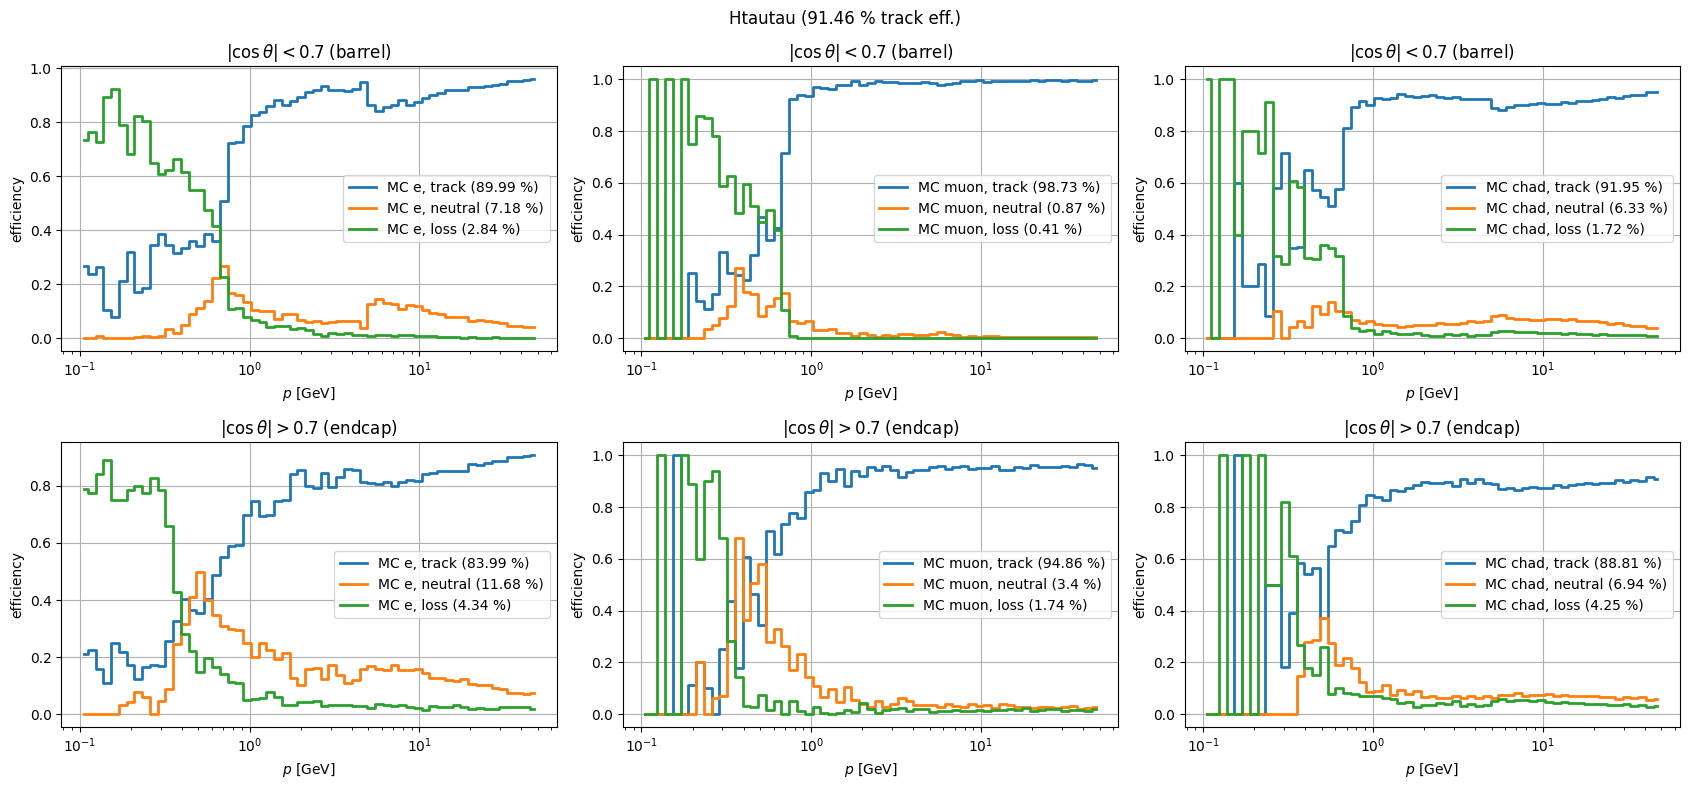

In [32]:
plot_pfo_alltype_sliced_theta(Htype="tautau", save=save_status)